In [24]:

import pandas as pd
import numpy as np
import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Flatten, Masking, TimeDistributed
from tensorflow.keras import mixed_precision
import shap
from sklearn.inspection import permutation_importance
import pickle
from sklearn.preprocessing import StandardScaler
from keras import backend as K

operating_system ='mac'
if operating_system == 'win':
    path = f'C:/Users/fabau/OneDrive/Documents/GitHub/master-project/'
else:
    path = f'/Users/fabienaugsburger/Documents/GitHub/master-project/'

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [25]:
#import the X and y data in the format .npy
dataset = 'X_y_EU_1h'

X_train = np.load(f'{path}DATASETS/{dataset}/X_train.npy')
y_train = np.load(f'{path}DATASETS/{dataset}/y_train.npy')
X_test = np.load(f'{path}DATASETS/{dataset}/X_test.npy')
y_test = np.load(f'{path}DATASETS/{dataset}/y_test.npy')
X_validation = np.load(f'{path}DATASETS/{dataset}/X_validation.npy')
y_validation = np.load(f'{path}DATASETS/{dataset}/y_validation.npy')

In [26]:
X_train[np.isnan(X_train)] = 0
X_test[np.isnan(X_test)] = 0
X_validation[np.isnan(X_validation)] = 0

y_train[np.isnan(y_train)] = 0
y_test[np.isnan(y_test)] = 0
y_validation[np.isnan(y_validation)] = 0


def masked_mse(y_true, y_pred):
    mask = K.cast(K.not_equal(y_true, 0), K.floatx())
    mse = K.square(y_pred - y_true)
    mse = mse * mask
    return K.sum(mse) / K.sum(mask)


In [27]:
# Define the model
model_Gia_3d = Sequential()

# Define the input shape in the first layer of the neural network
#input_shape = (X_train.shape[1], X_train.shape[2])

# Add a Conv1D layer with 32 filters and a kernel size of 3
#model_Gia.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))

#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)

# Add a Masking layer to handle NaNs (assuming NaNs are replaced with 0)
model_Gia_3d.add(Masking(mask_value=np.nan, input_shape=(X_train.shape[1],X_train.shape[2])))

# Add the first LSTM layer with 128 units
model_Gia_3d.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))

# Add the second LSTM layer with 256 units
#model_Gia_3d.add(LSTM(units=256, return_sequences=False, input_shape=(X_train.shape[1],X_train.shape[2])))

# Add a Dense (fully connected) layer with 128 units and tanh activation
model_Gia_3d.add(Dense(units=128, activation='tanh'))

# Flatten the output
model_Gia_3d.add(Flatten())

# Add the final Dense layer with a linear activation function
# Assuming the output length is predefined, for example, 1
output_length = X_train.shape[1]

#model_Gia_3d.add(TimeDistributed(Dense(units=1, activation='linear')))
model_Gia_3d.add(Dense(units=output_length, activation='linear'))

# Compile the model
model_Gia_3d.compile(optimizer='adam', loss='mse')

# Print the model summary
model_Gia_3d.summary()

/Users/fabienaugsburger/anaconda3/envs/tensor_flow/lib/python3.11/site-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/fabienaugsburger/anaconda3/envs/tensor_flow/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/fabienaugsburger/anaconda3/envs/tensor_flow/lib/python3.11/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'flatten_4' (of type Flatten) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
 

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_5 (Masking)             │ (None, 185, 79)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 185, 128)       │       106,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 185, 128)       │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 23680)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 185)            │     4,380,985 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,503,993 (17.18 MB)

 Trainable params: 4,503,993 (17.18 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
run_index = 13 # it should be an integer, e.g. 1

run_logdir = os.path.join(os.curdir, "LSTM_3d_logs/", "run_{:03d}".format(run_index))

print(run_logdir)

./LSTM_3d_logs/run_013


In [29]:
# Define callbacks (they can really improve the accuracy if well-chosen!)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("model_Gia_3d.keras", 
                                                   save_best_only=True,
                                                   monitor='loss')
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)

In [30]:
# Entraîner le modèle
model_Gia_3d.fit(X_train, y_train,
            validation_data=(X_validation, y_validation), 
            epochs=50, 
            verbose=1,  
            batch_size=32,
            callbacks=[early_stopping_cb, checkpoint_cb, tensorboard_cb],)
          #use_multiprocessing=True)

# Faire des prédictions
y_pred = model_Gia_3d.predict(X_test)

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 84.8410 - val_loss: 34.1162
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 26.9950 - val_loss: 18.7807
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 19.2452 - val_loss: 15.9108
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 14.9866 - val_loss: 17.2517
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 15.2023 - val_loss: 15.5299
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 11.6674 - val_loss: 12.9209
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 9.0038 - val_loss: 10.9779
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 8.0445 - val_loss: 10.2331
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 7.4263 - val_loss: 10.8080
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 6.8682 - val_loss: 10.7914
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 6.5358 - val_loss: 9.6355
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 5.4650 - val_

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


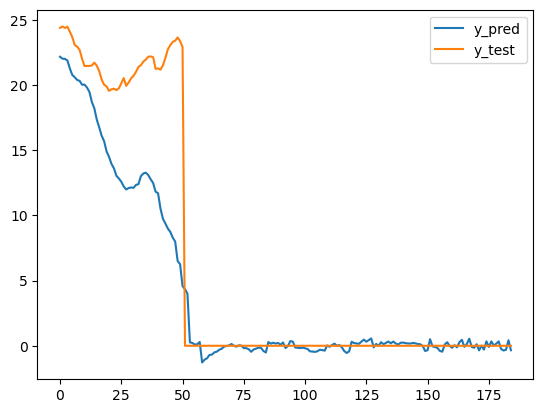

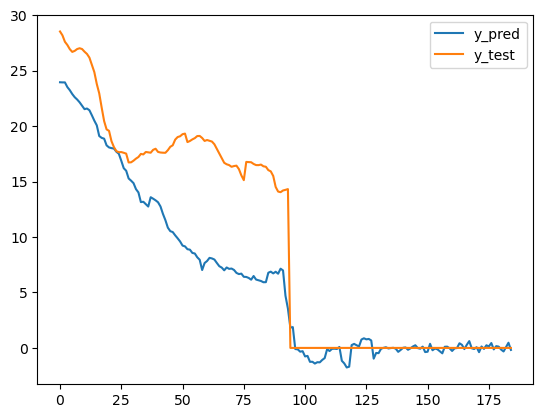

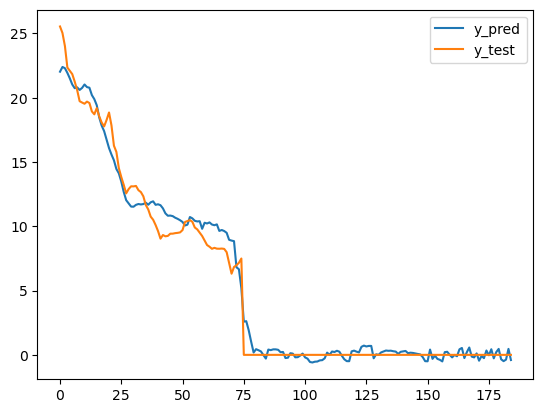

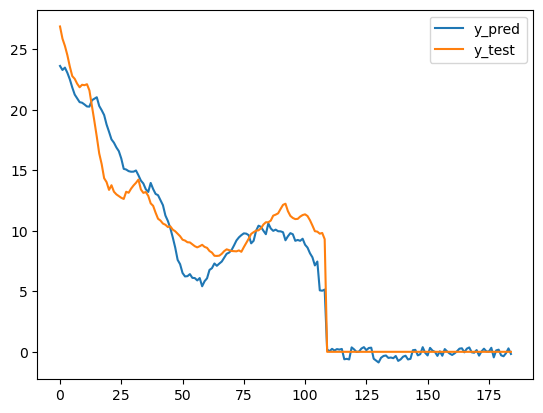

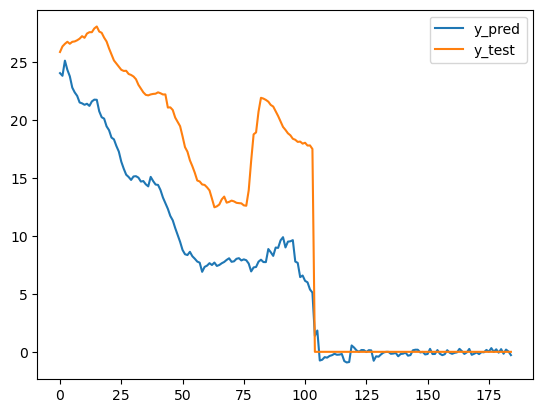

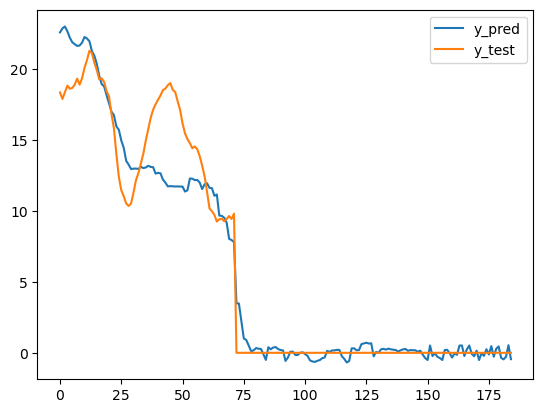

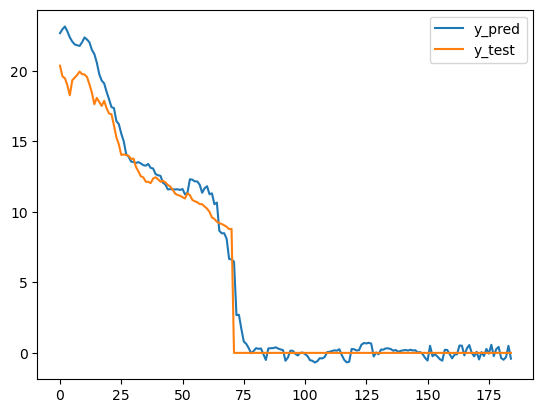

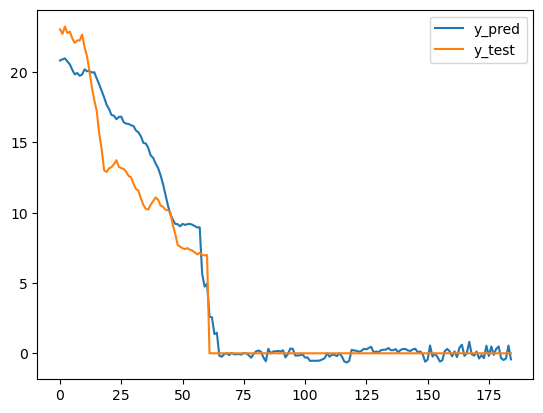

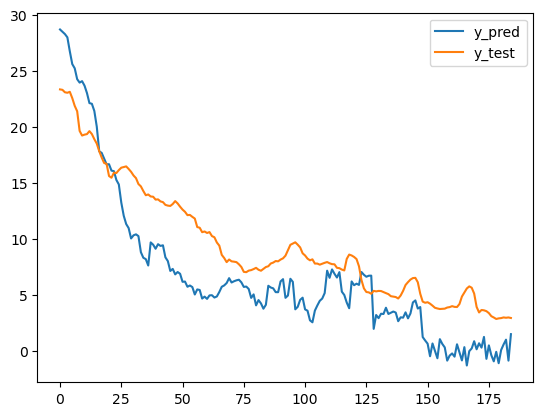

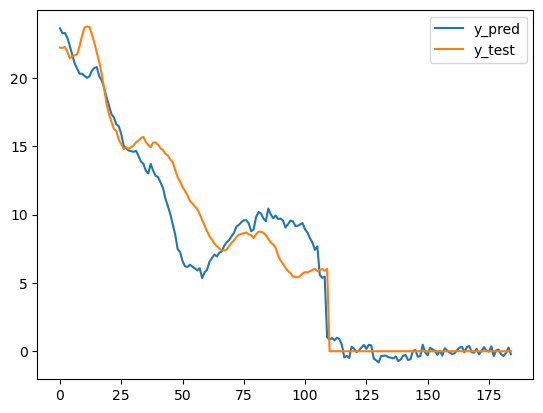

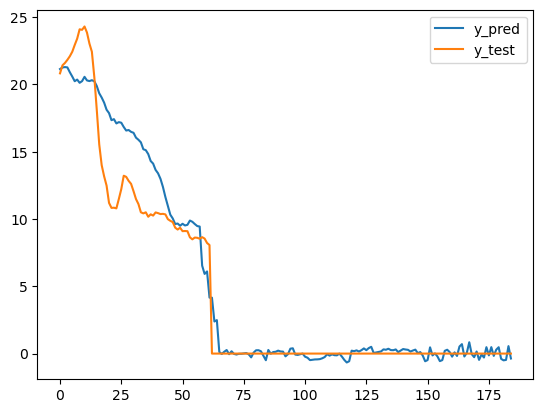

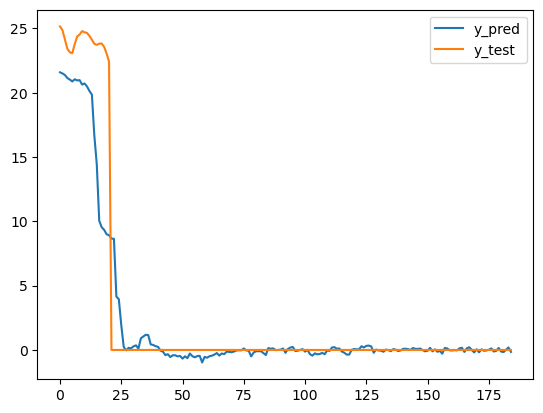

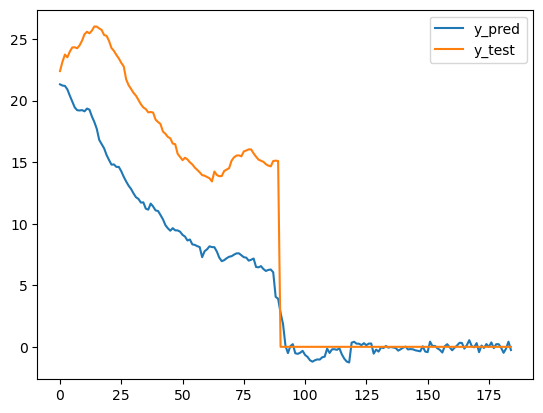

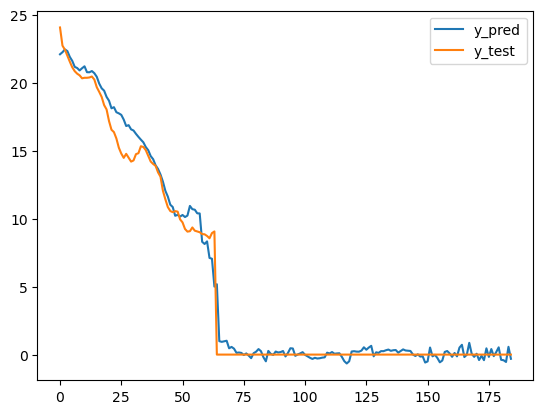

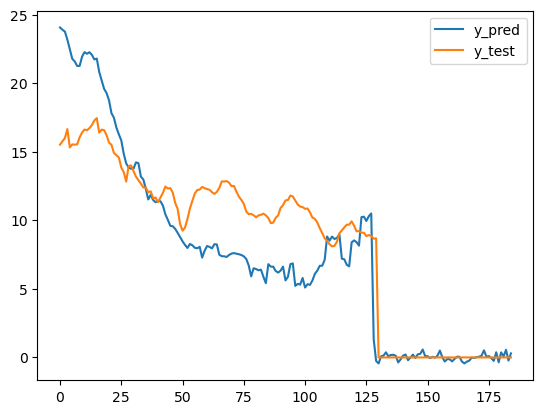

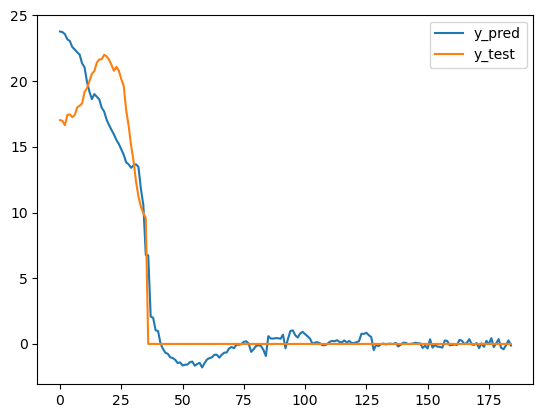

3.3134569258751285


In [31]:
y_pred_valid = model_Gia_3d.predict(X_test)
y_pred = y_pred_valid
storm_n = 0
for storm_n in range(0,len(y_pred_valid)):
    plt.plot(y_pred[storm_n,:], label='y_pred')
    plt.plot(y_test[storm_n,:], label='y_test')
    plt.legend()
    plt.show()

# calculate the RMSE

rms = (mean_squared_error(y_test,y_pred))**0.5
print(rms) 

In [28]:
# save model

#model_Gia_3d.save(f'{path}case_study/model_Gia_3d.keras')

# load model

model_Gia_3d = tf.keras.models.load_model(f'{path}case_study/model_Gia_3d.keras')

/Users/fabienaugsburger/anaconda3/envs/tensor_flow/lib/python3.11/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'flatten_4' (of type Flatten) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [48]:
# Example model prediction function (Replace with your actual model's prediction function)
def model_predict(data):
    # Reshape data to add the batch dimension
    if len(data.shape) == 2:
        data = np.expand_dims(data, axis=0)
    return model_Gia_3d.predict(data)

storm_choosen = range(4,5)
timesteps = range(100)  # Choose an index for the sample to explain
#sample = X_test[storm_choosen, :, :]
sample = X_test[:, timesteps, :]
test = X_train[:100]

# From 3D to 2D
#sample_reshaped = sample.reshape(sample.shape[1], sample.shape[2])

# Create a SHAP explainer (using a smaller subset for speed)
# Choose a sample that matches the input shape of the model
explainer = shap.KernelExplainer(model=model_Gia_3d.predict, data=X_train, link="identity")

# Compute SHAP values for a subset of the data
# Choose a different sample to compute SHAP values
#subset_index = 1  # Choose another index for the subset to explain

shap_values = explainer(X_test[:, :, :])
# Reshape SHAP values to match the input shape
#reshaped_shap_values = np.array(shap_values).reshape((X_test[subset_index, :, :].shape))

# Plot SHAP summary
shap.summary_plot(reshaped_shap_values, X_test[subset_index, :, :])

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


DimensionError: Instance must have 1 or 2 dimensions!

In [132]:
# Define the model
model_2_3d = Sequential()

# Define the input shape in the first layer of the neural network
#input_shape = (X_train.shape[1], X_train.shape[2])

# Add a Conv1D layer with 32 filters and a kernel size of 3
#model_Gia.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))

#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)

# Add a Masking layer to handle NaNs (assuming NaNs are replaced with 0)
model_2_3d.add(Masking(mask_value=0., input_shape=X_train.shape))

# Add the first LSTM layer with 128 units
model_2_3d.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))


model_2_3d.add(TimeDistributed(Dense(units=1, activation='linear')))

# Add the second LSTM layer with 256 units
#model_Gia_2.add(LSTM(units=256))

# Add a Dense (fully connected) layer with 128 units and tanh activation
#model_2_3d.add(Dense(units=128, activation='tanh'))

# Flatten the output
#model_2_3d.add(Flatten())

# Add the final Dense layer with a linear activation function
# Assuming the output length is predefined, for example, 1
#output_length = X_train.shape[1]

#model_Gia_3d.add(Dense(units=output_length, activation='linear'))

# Compile the model
model_2_3d.compile(optimizer='adam', loss=masked_mse)

# Print the model summary
model_2_3d.summary()

TypeError: __init__() got multiple values for argument 'units'

In [71]:
# Define a function to shuffle feature values
def permute_feature(X, feature_index):
    X_permuted = X.copy()
    np.random.shuffle(X_permuted[:, :, feature_index])
    return X_permuted

# feature names

var_names = pd.read_csv(f'{path}variable_list_24_v5_wo_i.csv')
feature_names = np.array(var_names['variables'])

# Calculate baseline performance
baseline_performance_best = mean_squared_error(y_train, best_model_2.predict(X_train))
baseline_performance = mean_squared_error(y_train, model_Gia_3d.predict(X_train))

# Initialize an empty list to hold feature importances
feature_importances = []

# Loop over each feature and calculate importance
for i in range(X_train.shape[2]):
    X_permuted = permute_feature(X_train, i)
    permuted_performance = mean_squared_error(y_train, best_model_2.predict(X_permuted))
    feature_importances.append(permuted_performance - baseline_performance)

# Plot feature importances
plt.figure(figsize=(10, 20))
plt.barh(range(X_train.shape[2]), feature_importances)
plt.yticks(range(X_train.shape[2]), feature_names)#np.array(["Feature " + str(i) for i in range(X_train.shape[2])]))
plt.xlabel("Feature Permutation Importance")
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


2024-06-23 21:55:08.420011: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: assertion failed: [You are passing a RNN mask that does not correspond to right-padded sequences, while using cuDNN, which is not supported. With cuDNN, RNN masks can only be used for right-padding, e.g. `[[True, True, False, False]]` would be a valid mask, but any mask that isn\'t just contiguous `True`\'s on the left and contiguous `False`\'s on the right would be invalid. You can pass `use_cudnn=False` to your RNN layer to stop using cuDNN (this may be slower).]
	 [[{{node sequential_172_1/lstm_299_1/Assert/Assert}}]]


InvalidArgumentError: Graph execution error:

Detected at node sequential_172_1/lstm_299_1/Assert/Assert defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/Users/fabienaugsburger/anaconda3/envs/tensor_flow/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/Users/fabienaugsburger/anaconda3/envs/tensor_flow/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/Users/fabienaugsburger/anaconda3/envs/tensor_flow/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 701, in start

  File "/Users/fabienaugsburger/anaconda3/envs/tensor_flow/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/Users/fabienaugsburger/anaconda3/envs/tensor_flow/lib/python3.11/asyncio/base_events.py", line 607, in run_forever

  File "/Users/fabienaugsburger/anaconda3/envs/tensor_flow/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once

  File "/Users/fabienaugsburger/anaconda3/envs/tensor_flow/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/Users/fabienaugsburger/anaconda3/envs/tensor_flow/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in dispatch_queue

  File "/Users/fabienaugsburger/anaconda3/envs/tensor_flow/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 523, in process_one

  File "/Users/fabienaugsburger/anaconda3/envs/tensor_flow/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 429, in dispatch_shell

  File "/Users/fabienaugsburger/anaconda3/envs/tensor_flow/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 767, in execute_request

  File "/Users/fabienaugsburger/anaconda3/envs/tensor_flow/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 429, in do_execute

  File "/Users/fabienaugsburger/anaconda3/envs/tensor_flow/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/Users/fabienaugsburger/anaconda3/envs/tensor_flow/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3051, in run_cell

  File "/Users/fabienaugsburger/anaconda3/envs/tensor_flow/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3106, in _run_cell

  File "/Users/fabienaugsburger/anaconda3/envs/tensor_flow/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/Users/fabienaugsburger/anaconda3/envs/tensor_flow/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3311, in run_cell_async

  File "/Users/fabienaugsburger/anaconda3/envs/tensor_flow/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3493, in run_ast_nodes

  File "/Users/fabienaugsburger/anaconda3/envs/tensor_flow/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/var/folders/01/5ryz4pnn581dj9gk6r1nn5qr0000gn/T/ipykernel_8595/2696796884.py", line 13, in <module>

  File "/Users/fabienaugsburger/anaconda3/envs/tensor_flow/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/fabienaugsburger/anaconda3/envs/tensor_flow/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 504, in predict

  File "/Users/fabienaugsburger/anaconda3/envs/tensor_flow/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 204, in one_step_on_data_distributed

  File "/Users/fabienaugsburger/anaconda3/envs/tensor_flow/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 194, in one_step_on_data

  File "/Users/fabienaugsburger/anaconda3/envs/tensor_flow/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 92, in predict_step

  File "/Users/fabienaugsburger/anaconda3/envs/tensor_flow/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/fabienaugsburger/anaconda3/envs/tensor_flow/lib/python3.11/site-packages/keras/src/layers/layer.py", line 846, in __call__

  File "/Users/fabienaugsburger/anaconda3/envs/tensor_flow/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/fabienaugsburger/anaconda3/envs/tensor_flow/lib/python3.11/site-packages/keras/src/ops/operation.py", line 48, in __call__

  File "/Users/fabienaugsburger/anaconda3/envs/tensor_flow/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/Users/fabienaugsburger/anaconda3/envs/tensor_flow/lib/python3.11/site-packages/keras/src/models/sequential.py", line 209, in call

  File "/Users/fabienaugsburger/anaconda3/envs/tensor_flow/lib/python3.11/site-packages/keras/src/models/functional.py", line 202, in call

  File "/Users/fabienaugsburger/anaconda3/envs/tensor_flow/lib/python3.11/site-packages/keras/src/ops/function.py", line 155, in _run_through_graph

  File "/Users/fabienaugsburger/anaconda3/envs/tensor_flow/lib/python3.11/site-packages/keras/src/models/functional.py", line 592, in call

  File "/Users/fabienaugsburger/anaconda3/envs/tensor_flow/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/fabienaugsburger/anaconda3/envs/tensor_flow/lib/python3.11/site-packages/keras/src/layers/layer.py", line 846, in __call__

  File "/Users/fabienaugsburger/anaconda3/envs/tensor_flow/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/fabienaugsburger/anaconda3/envs/tensor_flow/lib/python3.11/site-packages/keras/src/ops/operation.py", line 48, in __call__

  File "/Users/fabienaugsburger/anaconda3/envs/tensor_flow/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/Users/fabienaugsburger/anaconda3/envs/tensor_flow/lib/python3.11/site-packages/keras/src/layers/rnn/lstm.py", line 560, in call

  File "/Users/fabienaugsburger/anaconda3/envs/tensor_flow/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py", line 406, in call

  File "/Users/fabienaugsburger/anaconda3/envs/tensor_flow/lib/python3.11/site-packages/keras/src/layers/rnn/lstm.py", line 527, in inner_loop

  File "/Users/fabienaugsburger/anaconda3/envs/tensor_flow/lib/python3.11/site-packages/keras/src/backend/tensorflow/rnn.py", line 841, in lstm

  File "/Users/fabienaugsburger/anaconda3/envs/tensor_flow/lib/python3.11/site-packages/keras/src/backend/tensorflow/rnn.py", line 874, in _cudnn_lstm

  File "/Users/fabienaugsburger/anaconda3/envs/tensor_flow/lib/python3.11/site-packages/keras/src/backend/tensorflow/rnn.py", line 557, in _assert_valid_mask

assertion failed: [You are passing a RNN mask that does not correspond to right-padded sequences, while using cuDNN, which is not supported. With cuDNN, RNN masks can only be used for right-padding, e.g. `[[True, True, False, False]]` would be a valid mask, but any mask that isn\'t just contiguous `True`\'s on the left and contiguous `False`\'s on the right would be invalid. You can pass `use_cudnn=False` to your RNN layer to stop using cuDNN (this may be slower).]
	 [[{{node sequential_172_1/lstm_299_1/Assert/Assert}}]] [Op:__inference_one_step_on_data_distributed_105051]

In [155]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, TimeDistributed, Dense, LSTM, Masking

# Define the input shape (storm number, time steps, variables)
input_shape = (None, 68)

# Input layer
inputs = Input(shape=input_shape)

# Optional Masking layer to handle variable length sequences
masked = Masking(mask_value=0.0)(inputs)

# TimeDistributed layer wrapped around a Dense layer
td_dense = TimeDistributed(Dense(128, activation='relu'))(masked)

# We need to reshape the TimeDistributed layer's output to match LSTM input requirements
# Reshape to (batch_size * storm_number, timesteps, features)
#reshape_td = tf.reshape(td_dense, (-1, tf.shape(td_dense)[2], 32))

# LSTM layer to handle sequential data
lstm = LSTM(128, return_sequences=True)(td_dense)

lstm_2 = LSTM(256, return_sequences=True)(lstm)

# Reshape back to (batch_size, storm_number, timesteps, features)
#reshape_lstm = tf.reshape(lstm, (-1, 67, tf.shape(lstm)[1], 64))

# Another TimeDistributed layer for final dense layer
output_td = TimeDistributed(Dense(1))(lstm_2)

# Reshape to match the output shape (67, 472)
#outputs = tf.reshape(output_td, (-1, 472))
flattened = tf.reshape(output_td, (tf.shape(inputs)[0], -1))

# Create the model
model = Model(inputs, flattened)

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Print the model summary
model.summary()


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, None, 68)]   0           []                               
                                                                                                  
 masking_23 (Masking)           (None, None, 68)     0           ['input_8[0][0]']                
                                                                                                  
 time_distributed_19 (TimeDistr  (None, None, 128)   8832        ['masking_23[0][0]']             
 ibuted)                                                                                          
                                                                                                  
 lstm_25 (LSTM)                 (None, None, 128)    131584      ['time_distributed_19[0][0]

In [156]:
model.fit(X_train, y_train,
          validation_data=(X_validation, y_validation),
          epochs=50, 
          batch_size=32, 
          verbose=1)

Epoch 1/50
3/3 [==============================] - 13s 2s/step - loss: 70.0751 - val_loss: 59.0847
Epoch 2/50
3/3 [==============================] - 2s 635ms/step - loss: 31.9534 - val_loss: 88.7935
Epoch 3/50
3/3 [==============================] - 2s 582ms/step - loss: 20.6575 - val_loss: 119.1746
Epoch 4/50
3/3 [==============================] - 2s 586ms/step - loss: 15.6988 - val_loss: 92.3324
Epoch 5/50
3/3 [==============================] - 2s 589ms/step - loss: 10.9016 - val_loss: 73.8970
Epoch 6/50
3/3 [==============================] - 2s 607ms/step - loss: 8.7991 - val_loss: 84.3066
Epoch 7/50
3/3 [==============================] - 2s 593ms/step - loss: 6.4076 - val_loss: 96.7484
Epoch 8/50
3/3 [==============================] - 2s 596ms/step - loss: 5.5907 - val_loss: 104.3265
Epoch 9/50
3/3 [==============================] - 2s 594ms/step - loss: 4.8381 - val_loss: 112.4849
Epoch 10/50
3/3 [==============================] - 2s 635ms/step - loss: 4.2630 - val_loss: 132.8023
Ep

In [153]:
y_pred = model.predict(X_test)

1/1 [==============================] - 2s 2s/step


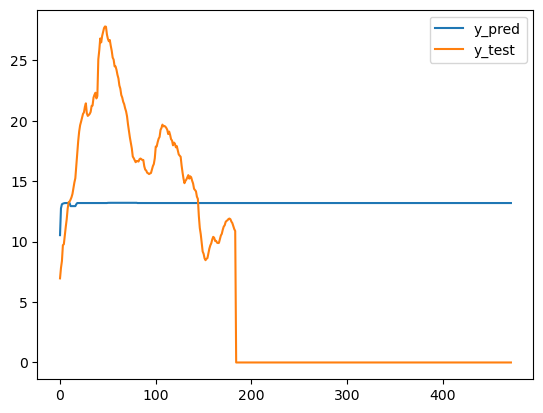

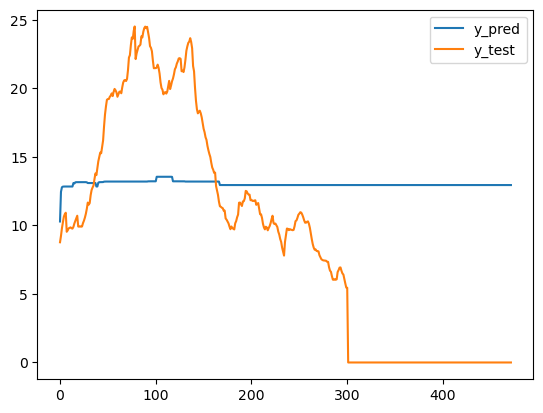

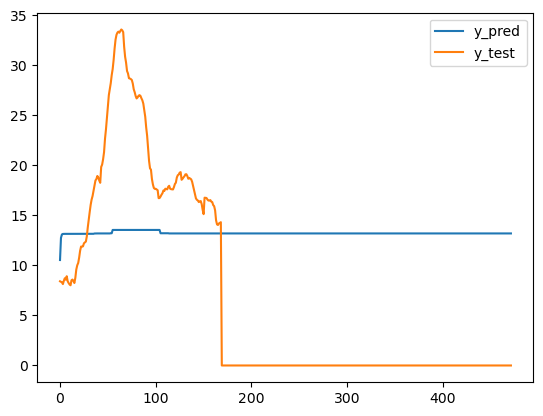

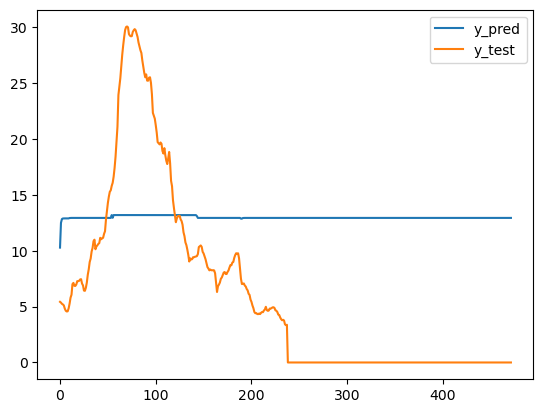

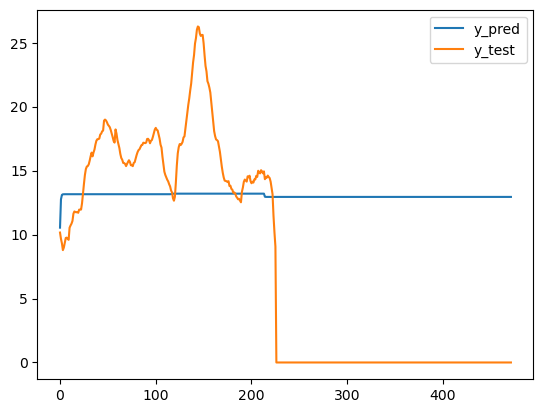

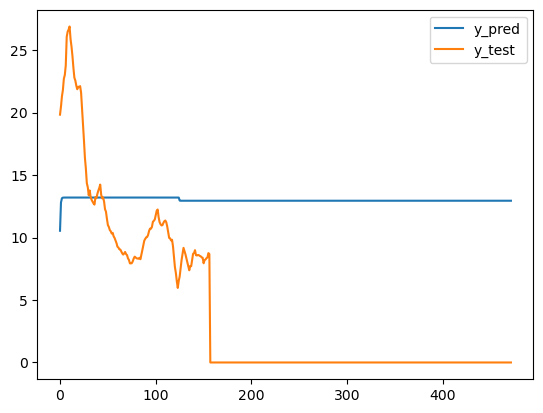

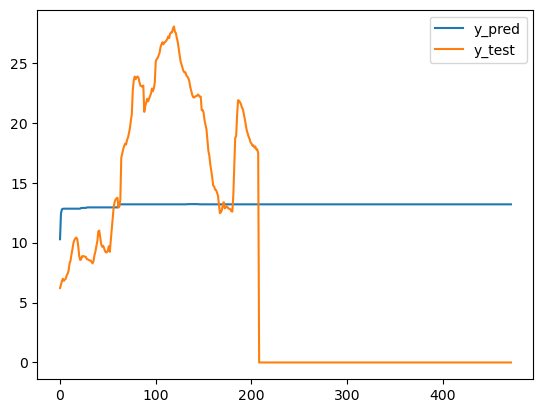

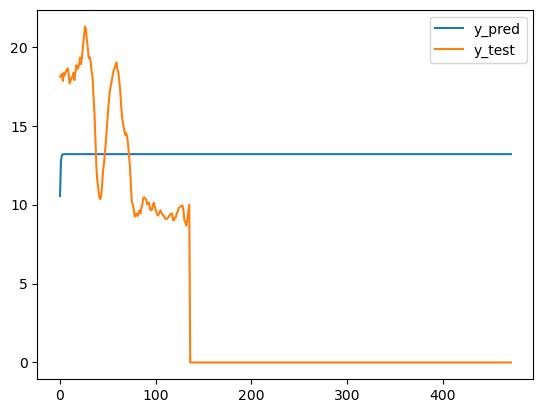

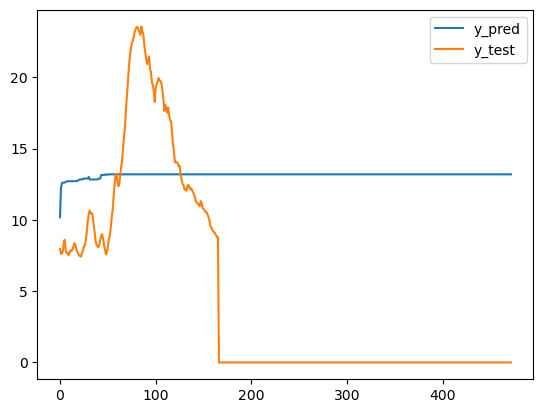

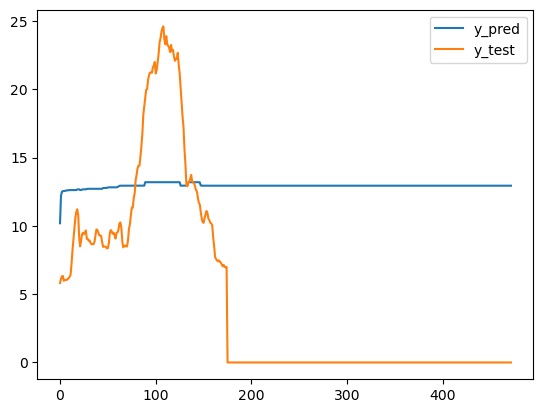

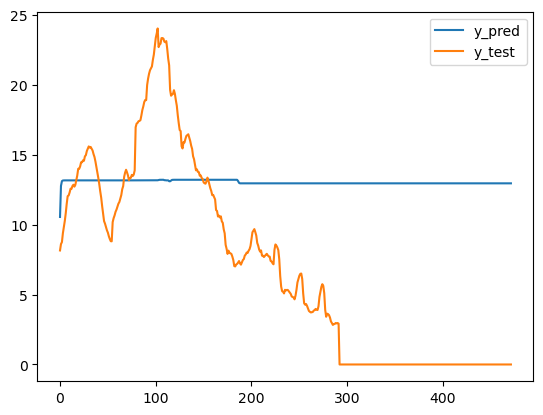

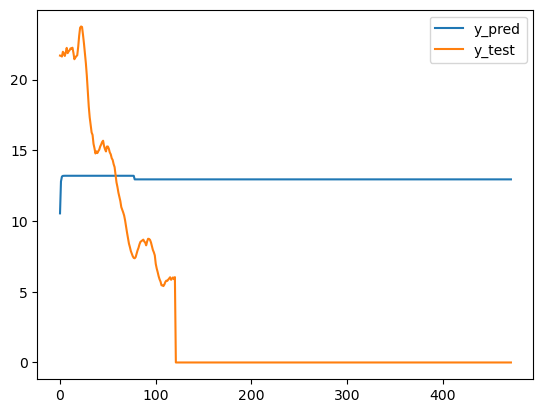

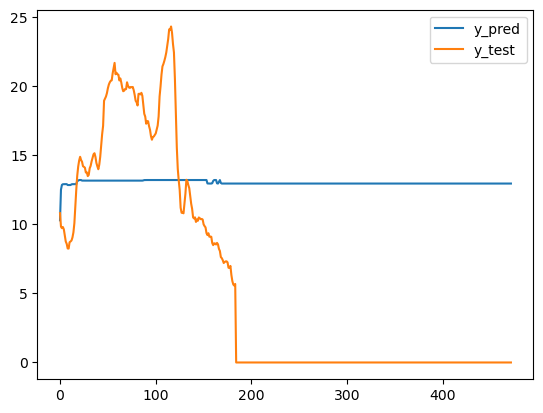

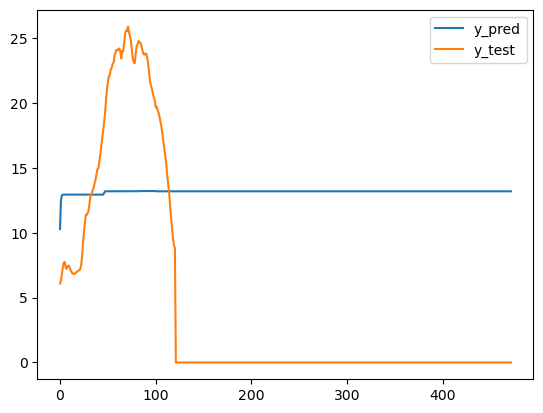

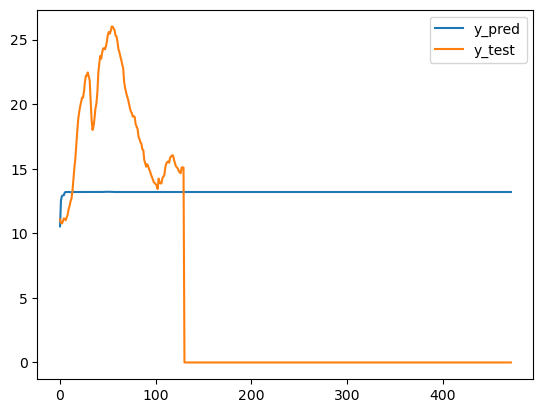

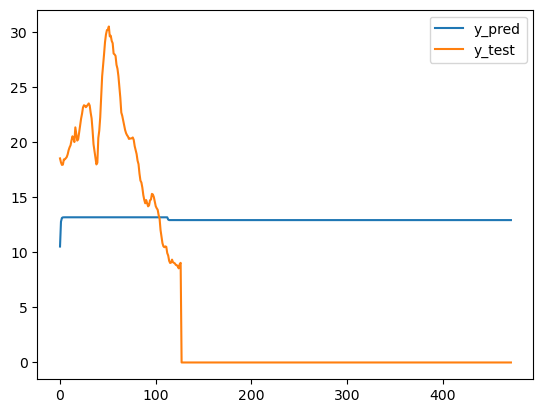

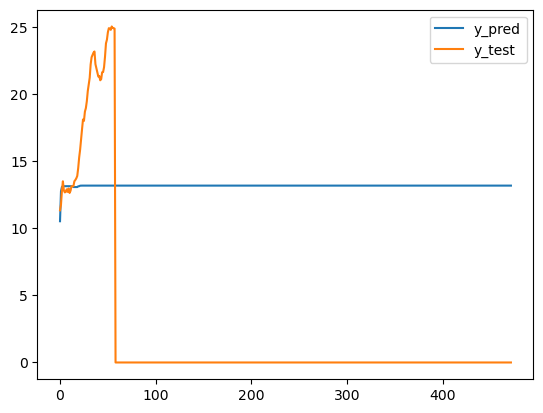

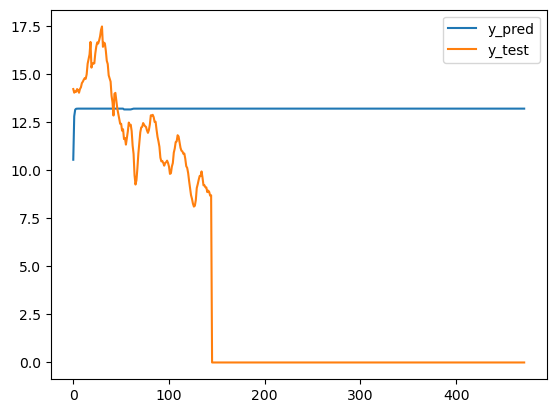

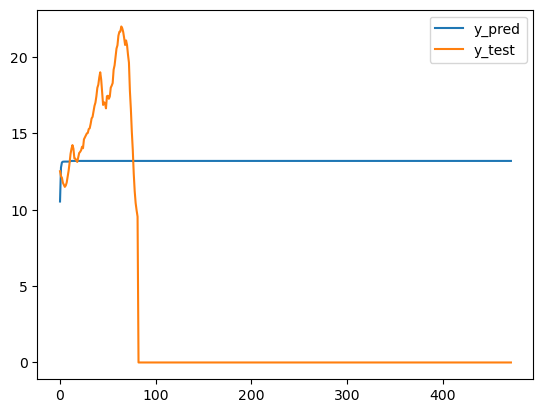

In [154]:
for storms in range(19):
    plt.plot(y_pred[storms,:], label='y_pred')
    plt.plot(y_test[storms,:], label='y_test')
    plt.legend()
    plt.show()

In [21]:
import optuna
from tensorflow.keras.optimizers import Adam


def create_model(trial):
    # Suggest hyperparameters
    n_units = trial.suggest_int('n_units', 50, 300)
    n_layers = trial.suggest_int('n_layers', 1, 3)
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    
    model = Sequential()
    # Add a Masking layer to handle NaNs (assuming NaNs are replaced with 0)
    model.add(Masking(mask_value=0., input_shape=(X_train.shape[1],X_train.shape[2])))

    # First LSTM layer
    model.add(LSTM(units=n_units, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2]))) #X_train_new.shape[2]
    model.add(tf.keras.layers.Dropout(dropout_rate))
    
    # Additional LSTM layers
    for _ in range(n_layers - 1):
        model.add(LSTM(units=n_units, return_sequences=True))
        model.add(tf.keras.layers.Dropout(dropout_rate))
    
    # Flatten and add Dense layers
    model.add(Flatten())
    model.add(Dense(units=128, activation='tanh'))

    output_length = X_train.shape[1]

    #model_Gia_3d.add(TimeDistributed(Dense(units=1, activation='linear')))
    model_Gia_3d.add(Dense(units=output_length, activation='linear'))
    #model.add(Dense(units=1, activation='linear'))
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    
    return model

def objective(trial):
    model = create_model(trial)
    
    # Train the model
    history = model.fit(X_train, y_train, 
                        validation_data=(X_validation, y_validation),
                        epochs=10,
                        batch_size=32,
                        verbose=1)
    
    # Evaluate the model
    loss = model.evaluate(X_validation, y_validation, verbose=0)
    
    return loss

In [22]:
# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, 
               n_trials=50,
               n_jobs=1)  # Use all available CPUs

# Get the best hyperparameters
print('Best hyperparameters: ', study.best_params)

[I 2024-06-22 23:01:36,517] A new study created in memory with name: no-name-4d94b2b7-2502-4841-8844-2139f1946c90


Epoch 1/10


/var/folders/01/5ryz4pnn581dj9gk6r1nn5qr0000gn/T/ipykernel_32896/3966588535.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
/var/folders/01/5ryz4pnn581dj9gk6r1nn5qr0000gn/T/ipykernel_32896/3966588535.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
/Users/fabienaugsburger/anaconda3/envs/tensor_flow/lib/python3.11/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'flatten_7' (of type Flatten) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Down

ValueError: Dimensions must be equal, but are 472 and 128 for '{{node compile_loss/mse/sub}} = Sub[T=DT_FLOAT](data_1, sequential_8_1/dense_14_1/Tanh)' with input shapes: [?,472], [?,128].

In [24]:
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Masking, LSTM, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

# Assuming you have already loaded and preprocessed X_train and y_train
# X_train should be of shape (num_samples, time_steps, num_features)
# y_train should be of shape (num_samples, output_length)

def create_model(trial):
    model = Sequential()
    
    # Suggest hyperparameters
    lstm_units_1 = trial.suggest_int('lstm_units_1', 32, 256, step=32)
    lstm_units_2 = trial.suggest_int('lstm_units_2', 32, 256, step=32)
    dense_units = trial.suggest_int('dense_units', 32, 256, step=32)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)

    # Define the input shape in the first layer of the neural network
    input_shape = (X_train.shape[1], X_train.shape[2])
    
    # Add a Masking layer to handle NaNs (assuming NaNs are replaced with 0)
    model.add(Masking(mask_value=0., input_shape=input_shape))

    # Add the first LSTM layer with suggested units
    model.add(LSTM(units=lstm_units_1, return_sequences=True, input_shape=input_shape))

    # Add the second LSTM layer with suggested units
    model.add(LSTM(units=lstm_units_2, return_sequences=False))

    # Add a Dense (fully connected) layer with suggested units and tanh activation
    model.add(Dense(units=dense_units, activation='tanh'))

    # Flatten the output
    model.add(Flatten())

    # Add the final Dense layer with a linear activation function
    output_length = X_train.shape[1]
    model.add(Dense(units=output_length, activation='linear'))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss=MeanSquaredError())
    
    return model

def objective(trial):
    model = create_model(trial)
    
    # Define early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    # Train the model
    history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, 
                        callbacks=[early_stopping], verbose=1)
    
    # Evaluate the model
    val_loss = np.min(history.history['val_loss'])
    return val_loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print("Best hyperparameters: ", study.best_params)

# Train the final model with the best hyperparameters
best_model = create_model(study.best_trial)
best_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, 
               callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])

# Print the summary of the final model
best_model.summary()

[I 2024-06-22 23:04:15,955] A new study created in memory with name: no-name-95154dd6-df4b-4c52-9c50-e2ff9f34c088


Epoch 1/50


/var/folders/01/5ryz4pnn581dj9gk6r1nn5qr0000gn/T/ipykernel_32896/102765860.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 608ms/step - loss: 78.0753 - val_loss: 81.7678
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 75.6821 - val_loss: 81.7663
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 78.5058 - val_loss: 81.7648
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 77.1504 - val_loss: 81.7633
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 77.8381 - val_loss: 81.7618
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 78.5790 - val_loss: 81.7602
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 74.4115 - val_loss: 81.7586
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 74.4772 - val_loss: 81.7570
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 74.4074 - val_loss: 81.7553
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 75.5650 - val_loss: 81.7536
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 74.9579 - val_loss: 81.7518
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 76.3

[I 2024-06-22 23:04:29,236] Trial 0 finished with value: 79.39838409423828 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dense_units': 128, 'learning_rate': 4.3328443464215344e-05}. Best is trial 0 with value: 79.39838409423828.


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 568ms/step - loss: 74.1709 - val_loss: 79.5126
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 70.4943 - val_loss: 73.7969
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 67.0363 - val_loss: 68.8302
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 64.3082 - val_loss: 63.9512
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 58.4636 - val_loss: 59.2085
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 53.8515 - val_loss: 54.7280
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 48.4768 - val_loss: 50.5811
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 46.8301 - val_loss: 46.7950
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 41.8934 - val_loss: 43.3703
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 41.7793 - val_loss: 40.2921
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 37.4327 - val_loss: 37.5748
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step -

[I 2024-06-22 23:04:41,926] Trial 1 finished with value: 23.756380081176758 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 256, 'dense_units': 64, 'learning_rate': 0.00581489644467052}. Best is trial 1 with value: 23.756380081176758.


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 594ms/step - loss: 76.9924 - val_loss: 81.7682
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 75.2356 - val_loss: 81.7671
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 76.2491 - val_loss: 81.7659
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 76.7451 - val_loss: 81.7648
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 78.7183 - val_loss: 81.7637
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 76.2229 - val_loss: 81.7625
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 76.8060 - val_loss: 81.7613
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 79.9909 - val_loss: 81.7601
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 74.8324 - val_loss: 81.7589
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 77.4095 - val_loss: 81.7577
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 76.7376 - val_loss: 81.7564
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step -

[I 2024-06-22 23:04:55,029] Trial 2 finished with value: 81.65708923339844 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 64, 'dense_units': 256, 'learning_rate': 2.686450537830286e-05}. Best is trial 1 with value: 23.756380081176758.


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 580ms/step - loss: 75.5779 - val_loss: 81.7476
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 74.7616 - val_loss: 81.7169
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 76.3560 - val_loss: 81.6646
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 77.6887 - val_loss: 81.5558
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 75.0066 - val_loss: 81.2645
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 75.7456 - val_loss: 80.2356
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 74.7721 - val_loss: 77.9389
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 74.2027 - val_loss: 76.7535
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 69.9294 - val_loss: 75.6944
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 69.4611 - val_loss: 74.5947
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 70.3376 - val_loss: 73.4836
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step -

[I 2024-06-22 23:05:10,290] Trial 3 finished with value: 46.02574920654297 and parameters: {'lstm_units_1': 160, 'lstm_units_2': 192, 'dense_units': 96, 'learning_rate': 0.0005087858783833867}. Best is trial 1 with value: 23.756380081176758.


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 580ms/step - loss: 77.3737 - val_loss: 81.7667
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 74.7997 - val_loss: 81.7640
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 74.5098 - val_loss: 81.7612
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 78.7676 - val_loss: 81.7583
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 74.3080 - val_loss: 81.7554
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 73.7990 - val_loss: 81.7523
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 75.9367 - val_loss: 81.7490
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 77.1279 - val_loss: 81.7455
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 76.2992 - val_loss: 81.7418
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 78.1986 - val_loss: 81.7378
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 78.4196 - val_loss: 81.7334
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step -

[I 2024-06-22 23:05:24,595] Trial 4 finished with value: 71.27629852294922 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 256, 'dense_units': 128, 'learning_rate': 6.345239281684645e-05}. Best is trial 1 with value: 23.756380081176758.


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 608ms/step - loss: 77.9441 - val_loss: 81.7664
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 74.7284 - val_loss: 81.7635
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 74.8055 - val_loss: 81.7606
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 75.5081 - val_loss: 81.7577
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 75.6213 - val_loss: 81.7547
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 77.0294 - val_loss: 81.7516
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 75.4865 - val_loss: 81.7484
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 75.7217 - val_loss: 81.7450
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 77.8046 - val_loss: 81.7415
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 76.7744 - val_loss: 81.7379
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 75.6331 - val_loss: 81.7340
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step -

[I 2024-06-22 23:05:37,755] Trial 5 finished with value: 78.8439712524414 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 64, 'dense_units': 160, 'learning_rate': 8.475475775489458e-05}. Best is trial 1 with value: 23.756380081176758.


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 659ms/step - loss: 75.2803 - val_loss: 78.5967
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 74.4650 - val_loss: 79.5829
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 74.6599 - val_loss: 69.4482
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 64.9824 - val_loss: 60.5772
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 55.5844 - val_loss: 52.9576
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 48.2203 - val_loss: 45.8688
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 39.5344 - val_loss: 39.6864
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 35.4146 - val_loss: 34.5658
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 31.5539 - val_loss: 30.5668
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 27.6754 - val_loss: 27.6857
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 23.9986 - val_loss: 25.7714
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step -

[I 2024-06-22 23:05:45,991] Trial 6 finished with value: 23.756662368774414 and parameters: {'lstm_units_1': 256, 'lstm_units_2': 224, 'dense_units': 96, 'learning_rate': 0.007865884740264475}. Best is trial 1 with value: 23.756380081176758.


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 608ms/step - loss: 75.7469 - val_loss: 81.7578
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 78.7866 - val_loss: 81.7449
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 74.9977 - val_loss: 81.7297
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 74.2916 - val_loss: 81.7114
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 75.4378 - val_loss: 81.6890
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 74.8543 - val_loss: 81.6610
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 75.2923 - val_loss: 81.6254
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 73.5799 - val_loss: 81.5793
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 75.6313 - val_loss: 81.5180
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 78.0907 - val_loss: 81.4342
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 73.7019 - val_loss: 81.3155
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step -

[I 2024-06-22 23:05:59,793] Trial 7 finished with value: 37.00471878051758 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 96, 'dense_units': 192, 'learning_rate': 0.000293996985608461}. Best is trial 1 with value: 23.756380081176758.


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 602ms/step - loss: 78.0575 - val_loss: 81.7668
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 76.9777 - val_loss: 81.7642
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 78.4479 - val_loss: 81.7615
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 77.7622 - val_loss: 81.7588
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 73.1445 - val_loss: 81.7559
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 78.6285 - val_loss: 81.7529
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 74.8856 - val_loss: 81.7497
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 77.1828 - val_loss: 81.7464
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 73.9757 - val_loss: 81.7429
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 76.4727 - val_loss: 81.7391
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 75.9421 - val_loss: 81.7350
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step -

[I 2024-06-22 23:06:14,827] Trial 8 finished with value: 77.89604949951172 and parameters: {'lstm_units_1': 96, 'lstm_units_2': 128, 'dense_units': 32, 'learning_rate': 8.67689923152777e-05}. Best is trial 1 with value: 23.756380081176758.


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 593ms/step - loss: 77.3171 - val_loss: 81.7668
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 75.1085 - val_loss: 81.7642
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 77.1098 - val_loss: 81.7615
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 77.2338 - val_loss: 81.7587
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 76.0346 - val_loss: 81.7559
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 74.8215 - val_loss: 81.7529
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 76.3986 - val_loss: 81.7498
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 75.2315 - val_loss: 81.7464
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 75.4121 - val_loss: 81.7429
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 75.2449 - val_loss: 81.7390
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 77.4335 - val_loss: 81.7349
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step -

[I 2024-06-22 23:06:30,147] Trial 9 finished with value: 69.39713287353516 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 224, 'dense_units': 192, 'learning_rate': 5.4411312808247856e-05}. Best is trial 1 with value: 23.756380081176758.


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 673ms/step - loss: 76.7867 - val_loss: 80.4463
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - loss: 76.8692 - val_loss: 76.5266
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 70.6895 - val_loss: 73.0768
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 68.9063 - val_loss: 69.6554
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 66.1933 - val_loss: 66.3170
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 63.6437 - val_loss: 63.0977
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 59.7245 - val_loss: 60.0172
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 56.1395 - val_loss: 57.0846
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 52.8641 - val_loss: 54.3060
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 52.5738 - val_loss: 51.6850
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 48.8199 - val_loss: 49.2295
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step -

[I 2024-06-22 23:06:46,078] Trial 10 finished with value: 23.915666580200195 and parameters: {'lstm_units_1': 224, 'lstm_units_2': 160, 'dense_units': 32, 'learning_rate': 0.007014210759459681}. Best is trial 1 with value: 23.756380081176758.


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 631ms/step - loss: 77.0333 - val_loss: 78.5583
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 71.7082 - val_loss: 85.8400
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 75.8057 - val_loss: 71.8992
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 65.3020 - val_loss: 64.4643
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 61.5685 - val_loss: 58.6824
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 55.2178 - val_loss: 53.1860
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 48.0446 - val_loss: 48.0485
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 45.0294 - val_loss: 43.4015
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 40.1226 - val_loss: 68.5433
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 58.7171 - val_loss: 39.7676
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 36.3677 - val_loss: 33.7934
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step -

[I 2024-06-22 23:06:57,041] Trial 11 finished with value: 23.804758071899414 and parameters: {'lstm_units_1': 256, 'lstm_units_2': 256, 'dense_units': 64, 'learning_rate': 0.008293791735589405}. Best is trial 1 with value: 23.756380081176758.


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 684ms/step - loss: 77.6681 - val_loss: 81.5669
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 75.3009 - val_loss: 77.3608
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 71.4581 - val_loss: 73.2657
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 67.6493 - val_loss: 69.5154
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 65.9555 - val_loss: 66.0833
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 63.6451 - val_loss: 62.8286
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 59.2052 - val_loss: 59.7113
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 56.8071 - val_loss: 56.7288
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 52.9381 - val_loss: 53.9016
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 50.6588 - val_loss: 51.2155
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 48.5239 - val_loss: 48.6933
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step -

[I 2024-06-22 23:07:13,139] Trial 12 finished with value: 23.779767990112305 and parameters: {'lstm_units_1': 192, 'lstm_units_2': 192, 'dense_units': 96, 'learning_rate': 0.002380470852620558}. Best is trial 1 with value: 23.756380081176758.


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 689ms/step - loss: 78.4103 - val_loss: 81.6741
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 76.5106 - val_loss: 80.8621
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 74.1183 - val_loss: 77.6237
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 73.3618 - val_loss: 75.8147
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 67.9283 - val_loss: 74.1615
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 67.9501 - val_loss: 72.5480
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 66.6959 - val_loss: 70.9389
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 65.6583 - val_loss: 69.3461
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 65.5826 - val_loss: 67.7792
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 64.2477 - val_loss: 66.2471
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 61.5355 - val_loss: 64.7521
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step -

[I 2024-06-22 23:07:29,514] Trial 13 finished with value: 32.44107437133789 and parameters: {'lstm_units_1': 192, 'lstm_units_2': 224, 'dense_units': 64, 'learning_rate': 0.0015037358445365349}. Best is trial 1 with value: 23.756380081176758.


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 738ms/step - loss: 78.8673 - val_loss: 81.5152
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - loss: 75.3829 - val_loss: 75.8165
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 70.7243 - val_loss: 72.2223
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 64.5838 - val_loss: 68.8183
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 62.7533 - val_loss: 65.4394
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 60.3024 - val_loss: 62.1733
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 59.3261 - val_loss: 59.0642
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 53.5437 - val_loss: 56.1006
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 51.9985 - val_loss: 53.2917
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 49.8636 - val_loss: 50.6240
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 47.9103 - val_loss: 48.1255
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step -

[I 2024-06-22 23:07:47,652] Trial 14 finished with value: 23.802785873413086 and parameters: {'lstm_units_1': 256, 'lstm_units_2': 256, 'dense_units': 96, 'learning_rate': 0.002424394560646286}. Best is trial 1 with value: 23.756380081176758.


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 704ms/step - loss: 78.2354 - val_loss: 81.7285
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 78.0714 - val_loss: 81.6367
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 75.7065 - val_loss: 81.2818
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 76.6922 - val_loss: 79.4619
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 73.0674 - val_loss: 77.9093
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 72.6563 - val_loss: 76.8243
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 74.0618 - val_loss: 75.7029
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 68.5292 - val_loss: 74.5960
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 68.8868 - val_loss: 73.5052
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 66.3125 - val_loss: 72.4342
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 66.5571 - val_loss: 71.3742
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step -

[I 2024-06-22 23:08:03,624] Trial 15 finished with value: 43.853271484375 and parameters: {'lstm_units_1': 160, 'lstm_units_2': 192, 'dense_units': 64, 'learning_rate': 0.0008801403682170374}. Best is trial 1 with value: 23.756380081176758.


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 698ms/step - loss: 78.0076 - val_loss: 80.9984
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 73.1086 - val_loss: 77.9617
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 71.4459 - val_loss: 75.8221
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 69.8902 - val_loss: 73.5878
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 68.4580 - val_loss: 71.3448
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 66.6372 - val_loss: 69.1407
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 62.7839 - val_loss: 66.9912
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 63.3158 - val_loss: 64.9078
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 61.5867 - val_loss: 62.8916
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 60.1930 - val_loss: 60.9442
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 57.6863 - val_loss: 59.0736
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step -

[I 2024-06-22 23:08:20,271] Trial 16 finished with value: 26.90838623046875 and parameters: {'lstm_units_1': 192, 'lstm_units_2': 224, 'dense_units': 32, 'learning_rate': 0.004353988438910189}. Best is trial 1 with value: 23.756380081176758.


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 702ms/step - loss: 76.6276 - val_loss: 81.7688
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 77.4045 - val_loss: 81.7683
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 77.5099 - val_loss: 81.7678
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 73.9187 - val_loss: 81.7672
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 75.4824 - val_loss: 81.7667
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 76.6753 - val_loss: 81.7662
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 78.1694 - val_loss: 81.7656
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 75.7676 - val_loss: 81.7651
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 74.4596 - val_loss: 81.7645
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 77.0966 - val_loss: 81.7640
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 73.7684 - val_loss: 81.7634
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step -

[I 2024-06-22 23:08:36,867] Trial 17 finished with value: 81.7328872680664 and parameters: {'lstm_units_1': 96, 'lstm_units_2': 160, 'dense_units': 160, 'learning_rate': 1.2215831434602448e-05}. Best is trial 1 with value: 23.756380081176758.


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 685ms/step - loss: 76.1349 - val_loss: 81.7567
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - loss: 77.1347 - val_loss: 81.7417
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 73.5703 - val_loss: 81.7227
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 75.9480 - val_loss: 81.6968
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 75.4619 - val_loss: 81.6582
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 75.1982 - val_loss: 81.5972
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 76.4839 - val_loss: 81.4904
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 75.4529 - val_loss: 81.2772
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 77.1497 - val_loss: 80.7757
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 74.1520 - val_loss: 79.3436
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 72.3184 - val_loss: 76.2243
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step -

[I 2024-06-22 23:08:53,846] Trial 18 finished with value: 39.99748611450195 and parameters: {'lstm_units_1': 224, 'lstm_units_2': 224, 'dense_units': 256, 'learning_rate': 0.00021545675479717164}. Best is trial 1 with value: 23.756380081176758.


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 678ms/step - loss: 76.4531 - val_loss: 81.5207
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 76.7727 - val_loss: 76.4992
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 71.9501 - val_loss: 70.5257
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 64.8402 - val_loss: 64.7926
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 60.2008 - val_loss: 80.2973
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 84.5965 - val_loss: 89.6630
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 79.8856 - val_loss: 79.8557
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 73.0535 - val_loss: 73.6647
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 64.7556 - val_loss: 69.0411


[I 2024-06-22 23:08:58,823] Trial 19 finished with value: 64.7925796508789 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 128, 'dense_units': 96, 'learning_rate': 0.0038338598608862657}. Best is trial 1 with value: 23.756380081176758.


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 740ms/step - loss: 75.8847 - val_loss: 81.7350
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 72.9761 - val_loss: 81.6708
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 75.6241 - val_loss: 81.4412
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 78.4805 - val_loss: 80.3428
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 74.1027 - val_loss: 79.6550
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 73.5021 - val_loss: 78.8688
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 74.5129 - val_loss: 77.9809
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 73.8417 - val_loss: 77.0107
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 71.4925 - val_loss: 75.9852
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 70.4342 - val_loss: 74.9227
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 70.6323 - val_loss: 73.8279
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step -

[I 2024-06-22 23:09:13,873] Trial 20 finished with value: 40.224769592285156 and parameters: {'lstm_units_1': 224, 'lstm_units_2': 32, 'dense_units': 64, 'learning_rate': 0.0009601914641309971}. Best is trial 1 with value: 23.756380081176758.


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 719ms/step - loss: 75.7418 - val_loss: 81.5338
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 74.4713 - val_loss: 76.2393
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 67.4957 - val_loss: 72.0867
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - loss: 64.8451 - val_loss: 68.1671
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 64.2584 - val_loss: 64.3564
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - loss: 58.2775 - val_loss: 60.7191
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 54.9614 - val_loss: 57.2249
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 54.2705 - val_loss: 53.9140
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 47.4298 - val_loss: 50.8014
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 46.1263 - val_loss: 47.9005
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 42.9871 - val_loss: 45.2218
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step -

[I 2024-06-22 23:09:30,504] Trial 21 finished with value: 23.80067253112793 and parameters: {'lstm_units_1': 192, 'lstm_units_2': 192, 'dense_units': 96, 'learning_rate': 0.002801569940786975}. Best is trial 1 with value: 23.756380081176758.


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 809ms/step - loss: 77.1391 - val_loss: 78.3218
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - loss: 72.9220 - val_loss: 64.4196
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 58.9458 - val_loss: 52.7015
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 47.0968 - val_loss: 42.7922
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 37.2387 - val_loss: 34.5946
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 33.2571 - val_loss: 28.9371
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 27.9183 - val_loss: 25.5747
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 24.9766 - val_loss: 24.0823
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 23.6314 - val_loss: 23.9012
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 21.4300 - val_loss: 24.3728
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 23.5712 - val_loss: 24.9248
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step -

[I 2024-06-22 23:09:37,914] Trial 22 finished with value: 23.901187896728516 and parameters: {'lstm_units_1': 256, 'lstm_units_2': 192, 'dense_units': 128, 'learning_rate': 0.009303170260623482}. Best is trial 1 with value: 23.756380081176758.


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 755ms/step - loss: 75.7813 - val_loss: 81.6381
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 77.1674 - val_loss: 79.0093
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - loss: 72.2945 - val_loss: 75.0637
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 67.1255 - val_loss: 71.9897
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 64.7196 - val_loss: 69.1829
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 63.5932 - val_loss: 66.4945
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 63.0914 - val_loss: 63.8856
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 60.2597 - val_loss: 61.3627
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 55.9714 - val_loss: 58.9307
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 51.7624 - val_loss: 56.5984
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 50.5066 - val_loss: 54.3623
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step -

[I 2024-06-22 23:09:54,959] Trial 23 finished with value: 24.61008071899414 and parameters: {'lstm_units_1': 160, 'lstm_units_2': 256, 'dense_units': 96, 'learning_rate': 0.0018369488367507639}. Best is trial 1 with value: 23.756380081176758.


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 764ms/step - loss: 78.5210 - val_loss: 81.1492
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 76.3595 - val_loss: 75.3587
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 70.3992 - val_loss: 71.3920
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 68.2165 - val_loss: 67.3153
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 64.1759 - val_loss: 63.2839
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 58.1193 - val_loss: 59.4157
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 56.3784 - val_loss: 55.7396
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 50.0613 - val_loss: 52.2953
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 46.9588 - val_loss: 49.0906
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 46.4389 - val_loss: 46.1443
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 42.1270 - val_loss: 43.4495
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step -

[I 2024-06-22 23:10:10,469] Trial 24 finished with value: 23.84024429321289 and parameters: {'lstm_units_1': 192, 'lstm_units_2': 224, 'dense_units': 64, 'learning_rate': 0.004551941444895209}. Best is trial 1 with value: 23.756380081176758.


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 762ms/step - loss: 77.7718 - val_loss: 80.5678
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 71.7341 - val_loss: 68.5796
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 63.8552 - val_loss: 59.8702
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 55.1072 - val_loss: 51.8419
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 48.3700 - val_loss: 44.7140
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 41.7373 - val_loss: 38.6001
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 35.1336 - val_loss: 33.6134
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 31.7373 - val_loss: 29.8276
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 29.6064 - val_loss: 27.1621
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 24.1733 - val_loss: 25.4324
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 22.4975 - val_loss: 24.4445
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step -

[I 2024-06-22 23:10:18,881] Trial 25 finished with value: 23.852800369262695 and parameters: {'lstm_units_1': 224, 'lstm_units_2': 160, 'dense_units': 128, 'learning_rate': 0.0057810928625852895}. Best is trial 1 with value: 23.756380081176758.


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 860ms/step - loss: 77.5299 - val_loss: 81.7247
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 76.5654 - val_loss: 81.6238
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 75.8688 - val_loss: 81.1293
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 74.3049 - val_loss: 79.3248
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 72.5887 - val_loss: 78.3674
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 74.4090 - val_loss: 77.6222
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 72.3793 - val_loss: 76.9128
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 69.6590 - val_loss: 76.2134
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 70.7295 - val_loss: 75.5120
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 69.4807 - val_loss: 74.8125
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 71.8941 - val_loss: 74.1166
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step -

[I 2024-06-22 23:10:34,708] Trial 26 finished with value: 53.44615936279297 and parameters: {'lstm_units_1': 96, 'lstm_units_2': 192, 'dense_units': 32, 'learning_rate': 0.001148944123066037}. Best is trial 1 with value: 23.756380081176758.


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 753ms/step - loss: 77.8714 - val_loss: 81.5129
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 73.7480 - val_loss: 76.2332
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 71.6978 - val_loss: 72.2341
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 68.5753 - val_loss: 68.6227
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 63.8784 - val_loss: 65.1058
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 61.3884 - val_loss: 61.7076
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 59.0603 - val_loss: 58.4519
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 51.9699 - val_loss: 55.3539
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 49.6581 - val_loss: 52.4093
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 49.3518 - val_loss: 49.6418
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 45.2755 - val_loss: 47.0549
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step -

[I 2024-06-22 23:10:53,819] Trial 27 finished with value: 23.823843002319336 and parameters: {'lstm_units_1': 160, 'lstm_units_2': 256, 'dense_units': 96, 'learning_rate': 0.002582265429146856}. Best is trial 1 with value: 23.756380081176758.


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 758ms/step - loss: 76.8750 - val_loss: 81.7351
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - loss: 78.0209 - val_loss: 81.6651
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - loss: 76.7401 - val_loss: 81.4209
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 73.1350 - val_loss: 79.5048
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 75.6102 - val_loss: 76.1773
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 71.5874 - val_loss: 74.2731
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 66.2729 - val_loss: 72.3265
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 64.4603 - val_loss: 70.3940
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 64.3476 - val_loss: 68.5277
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 64.3101 - val_loss: 66.7405
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 61.5404 - val_loss: 65.0342
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step -

[I 2024-06-22 23:11:11,852] Trial 28 finished with value: 31.40610122680664 and parameters: {'lstm_units_1': 256, 'lstm_units_2': 224, 'dense_units': 160, 'learning_rate': 0.0005996719899677023}. Best is trial 1 with value: 23.756380081176758.


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 701ms/step - loss: 77.4180 - val_loss: 81.7621
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 77.6096 - val_loss: 81.7544
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 76.4402 - val_loss: 81.7457
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 76.4515 - val_loss: 81.7356
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 77.1823 - val_loss: 81.7234
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 76.7957 - val_loss: 81.7082
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 74.1310 - val_loss: 81.6890
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 76.7337 - val_loss: 81.6639
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 77.3445 - val_loss: 81.6296
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 75.5640 - val_loss: 81.5811
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 75.7283 - val_loss: 81.5099
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step -

[I 2024-06-22 23:11:27,142] Trial 29 finished with value: 58.7957763671875 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 160, 'dense_units': 128, 'learning_rate': 0.0001743528146918875}. Best is trial 1 with value: 23.756380081176758.


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 780ms/step - loss: 78.1218 - val_loss: 80.7839
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - loss: 73.5956 - val_loss: 75.1417
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 69.4663 - val_loss: 71.6907
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 62.9976 - val_loss: 68.2071
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 62.0517 - val_loss: 64.7582
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 58.8310 - val_loss: 61.4411
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 57.4803 - val_loss: 58.2826
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 54.7157 - val_loss: 55.2809
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 50.2157 - val_loss: 52.4434
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 46.8656 - val_loss: 49.7896
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 47.0141 - val_loss: 47.3049
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step -

[I 2024-06-22 23:11:44,757] Trial 30 finished with value: 23.788740158081055 and parameters: {'lstm_units_1': 192, 'lstm_units_2': 256, 'dense_units': 64, 'learning_rate': 0.0037741618209168317}. Best is trial 1 with value: 23.756380081176758.


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 838ms/step - loss: 76.3804 - val_loss: 79.1618
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - loss: 73.9501 - val_loss: 70.3221
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 66.8532 - val_loss: 62.8787
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - loss: 57.0671 - val_loss: 55.8052
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 49.2448 - val_loss: 49.2327
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 45.8095 - val_loss: 43.4430
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 38.3581 - val_loss: 38.4563
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 36.2041 - val_loss: 34.3179
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 33.0165 - val_loss: 30.9815
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 29.7510 - val_loss: 28.4404
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 27.0803 - val_loss: 26.6137
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step -

[I 2024-06-22 23:11:54,639] Trial 31 finished with value: 23.697662353515625 and parameters: {'lstm_units_1': 192, 'lstm_units_2': 256, 'dense_units': 64, 'learning_rate': 0.009973209900399547}. Best is trial 31 with value: 23.697662353515625.


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 761ms/step - loss: 74.4209 - val_loss: 79.0284
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - loss: 73.3250 - val_loss: 72.5417
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 67.8848 - val_loss: 66.4144
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 60.3681 - val_loss: 60.3860
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 54.8124 - val_loss: 54.8230
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 50.8934 - val_loss: 49.8440
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 44.1377 - val_loss: 45.3049
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 40.5229 - val_loss: 41.2873
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 39.3006 - val_loss: 37.7849
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 33.5840 - val_loss: 34.8035
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 33.2120 - val_loss: 32.2772
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step -

[I 2024-06-22 23:12:06,641] Trial 32 finished with value: 23.79603385925293 and parameters: {'lstm_units_1': 224, 'lstm_units_2': 224, 'dense_units': 64, 'learning_rate': 0.007137189014333729}. Best is trial 31 with value: 23.697662353515625.


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 766ms/step - loss: 74.4276 - val_loss: 76.7458
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 70.0488 - val_loss: 65.6037
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 58.7907 - val_loss: 55.7272
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 48.9200 - val_loss: 46.8616
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 43.2302 - val_loss: 39.4702
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 36.9186 - val_loss: 33.5673
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 30.9772 - val_loss: 29.3793
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 28.4737 - val_loss: 26.5393
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 25.7960 - val_loss: 24.7745
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 24.9258 - val_loss: 23.9153
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 23.9698 - val_loss: 23.7555
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step -

[I 2024-06-22 23:12:14,602] Trial 33 finished with value: 23.755462646484375 and parameters: {'lstm_units_1': 160, 'lstm_units_2': 256, 'dense_units': 96, 'learning_rate': 0.009313360077653968}. Best is trial 31 with value: 23.697662353515625.


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 835ms/step - loss: 72.8199 - val_loss: 79.3088
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - loss: 70.7038 - val_loss: 74.8176
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 70.8541 - val_loss: 70.4545
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 64.2724 - val_loss: 66.1795
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 62.0812 - val_loss: 62.1063
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 56.1649 - val_loss: 58.2593
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 55.4401 - val_loss: 54.6566
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 51.7353 - val_loss: 51.2836
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 48.8608 - val_loss: 48.1640
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 44.4696 - val_loss: 45.3120
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 39.9961 - val_loss: 42.6921
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step -

[I 2024-06-22 23:12:31,577] Trial 34 finished with value: 23.75816535949707 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 256, 'dense_units': 32, 'learning_rate': 0.009146464498006051}. Best is trial 31 with value: 23.697662353515625.


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 893ms/step - loss: 76.7709 - val_loss: 80.3232
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - loss: 69.7120 - val_loss: 68.0233
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - loss: 62.5481 - val_loss: 60.4148
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 56.6019 - val_loss: 53.1486
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 47.0713 - val_loss: 46.5359
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 43.7370 - val_loss: 40.7291
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 37.8696 - val_loss: 35.8603
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 32.3260 - val_loss: 31.9530
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 30.8217 - val_loss: 28.9716
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 27.8649 - val_loss: 26.8194
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 24.1515 - val_loss: 25.3778
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step -

[I 2024-06-22 23:12:41,539] Trial 35 finished with value: 23.75240135192871 and parameters: {'lstm_units_1': 160, 'lstm_units_2': 256, 'dense_units': 128, 'learning_rate': 0.005148157108210929}. Best is trial 31 with value: 23.697662353515625.


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 848ms/step - loss: 76.0378 - val_loss: 78.5853
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 72.9238 - val_loss: 68.0787
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - loss: 62.2560 - val_loss: 60.0549
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 54.7117 - val_loss: 52.6470
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 48.5794 - val_loss: 45.9601
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 42.6558 - val_loss: 40.1723
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 37.5374 - val_loss: 35.3836
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - loss: 33.1705 - val_loss: 31.5690
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 30.6174 - val_loss: 28.6326
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 27.6640 - val_loss: 26.5528
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 25.7523 - val_loss: 25.1821
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step -

[I 2024-06-22 23:12:50,694] Trial 36 finished with value: 23.81254768371582 and parameters: {'lstm_units_1': 160, 'lstm_units_2': 256, 'dense_units': 128, 'learning_rate': 0.005216543057343429}. Best is trial 31 with value: 23.697662353515625.


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 898ms/step - loss: 76.3609 - val_loss: 80.8737
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - loss: 72.4884 - val_loss: 66.4964
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - loss: 62.3544 - val_loss: 56.5640
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - loss: 49.2041 - val_loss: 48.2576
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 44.0624 - val_loss: 41.0741
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - loss: 38.1213 - val_loss: 35.1451
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 33.7912 - val_loss: 30.5885
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 26.5890 - val_loss: 27.3946
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 27.0121 - val_loss: 25.3403
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 22.8024 - val_loss: 24.2565
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 21.2771 - val_loss: 23.8313
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step -

[I 2024-06-22 23:12:59,719] Trial 37 finished with value: 23.83131980895996 and parameters: {'lstm_units_1': 160, 'lstm_units_2': 256, 'dense_units': 224, 'learning_rate': 0.003689624112778088}. Best is trial 31 with value: 23.697662353515625.


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 872ms/step - loss: 77.2477 - val_loss: 79.9402
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 70.2613 - val_loss: 65.9927
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 61.7236 - val_loss: 56.6888
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 53.2984 - val_loss: 48.7192
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 47.1177 - val_loss: 41.7900
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 39.9206 - val_loss: 36.0310
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 34.3859 - val_loss: 31.5201
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 29.8478 - val_loss: 28.2156
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 25.2787 - val_loss: 25.9648
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 22.3957 - val_loss: 24.6474
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 24.3062 - val_loss: 24.0307
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step -

[I 2024-06-22 23:13:10,675] Trial 38 finished with value: 23.81608772277832 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 256, 'dense_units': 128, 'learning_rate': 0.006031128196390859}. Best is trial 31 with value: 23.697662353515625.


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 865ms/step - loss: 78.7058 - val_loss: 81.6617
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 77.1366 - val_loss: 79.6662
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 71.4668 - val_loss: 74.4583
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - loss: 67.5882 - val_loss: 70.2931
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - loss: 63.2562 - val_loss: 66.3031
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 63.4015 - val_loss: 62.6705
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - loss: 58.3861 - val_loss: 59.3215
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 55.6359 - val_loss: 56.1527
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 52.4257 - val_loss: 53.1565
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 50.2805 - val_loss: 50.3229
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 46.8062 - val_loss: 47.6679
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step -

[I 2024-06-22 23:13:27,872] Trial 39 finished with value: 23.865468978881836 and parameters: {'lstm_units_1': 96, 'lstm_units_2': 224, 'dense_units': 160, 'learning_rate': 0.0015011452055160293}. Best is trial 31 with value: 23.697662353515625.


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 782ms/step - loss: 79.2304 - val_loss: 81.7513
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 73.2692 - val_loss: 81.7284
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 73.0993 - val_loss: 81.6956
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 75.6003 - val_loss: 81.6440
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 77.2456 - val_loss: 81.5527
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 75.8914 - val_loss: 81.3650
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 75.8931 - val_loss: 80.8585
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 75.3502 - val_loss: 78.9881
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 72.9090 - val_loss: 77.3811
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 70.9245 - val_loss: 76.0661
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 71.2577 - val_loss: 74.6453
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step -

[I 2024-06-22 23:13:43,789] Trial 40 finished with value: 30.776851654052734 and parameters: {'lstm_units_1': 160, 'lstm_units_2': 64, 'dense_units': 192, 'learning_rate': 0.0004499094366027656}. Best is trial 31 with value: 23.697662353515625.


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 781ms/step - loss: 75.2361 - val_loss: 76.3365
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 70.0757 - val_loss: 64.4622
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 56.0281 - val_loss: 54.6383
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - loss: 49.7554 - val_loss: 45.9986
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 41.3568 - val_loss: 38.7492
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 36.1203 - val_loss: 33.1467
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 28.9246 - val_loss: 29.0878
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 27.8894 - val_loss: 26.3017
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 25.4688 - val_loss: 24.6551
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 24.0862 - val_loss: 23.9239
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 23.6477 - val_loss: 23.7988
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step -

[I 2024-06-22 23:13:52,386] Trial 41 finished with value: 23.79884910583496 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 256, 'dense_units': 96, 'learning_rate': 0.009015283177643824}. Best is trial 31 with value: 23.697662353515625.


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 990ms/step - loss: 77.5423 - val_loss: 80.3714
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - loss: 75.6555 - val_loss: 69.6867
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 66.4119 - val_loss: 62.5524
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 55.7863 - val_loss: 55.9730
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 52.2495 - val_loss: 49.8395
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 45.1359 - val_loss: 44.3235
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 40.9695 - val_loss: 39.5460
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 35.5938 - val_loss: 35.5179
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 30.8231 - val_loss: 32.2243
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 28.1601 - val_loss: 29.6193
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 28.1715 - val_loss: 27.6512
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step -

[I 2024-06-22 23:14:10,137] Trial 42 finished with value: 22.79323959350586 and parameters: {'lstm_units_1': 160, 'lstm_units_2': 224, 'dense_units': 96, 'learning_rate': 0.0058582330618276585}. Best is trial 42 with value: 22.79323959350586.


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 962ms/step - loss: 77.5485 - val_loss: 80.6734
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - loss: 73.8550 - val_loss: 74.1159
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 70.7399 - val_loss: 68.8732
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 65.8806 - val_loss: 63.6611
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 56.8180 - val_loss: 58.6340
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 52.1794 - val_loss: 53.9149
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - loss: 46.9461 - val_loss: 49.5619
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 45.4592 - val_loss: 45.6083
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 39.7849 - val_loss: 42.0577
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 39.5656 - val_loss: 38.9083
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 37.2786 - val_loss: 36.1465
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step -

[I 2024-06-22 23:14:23,708] Trial 43 finished with value: 23.78433609008789 and parameters: {'lstm_units_1': 160, 'lstm_units_2': 256, 'dense_units': 64, 'learning_rate': 0.006123384042272488}. Best is trial 42 with value: 22.79323959350586.


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 910ms/step - loss: 75.4435 - val_loss: 81.5788
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - loss: 72.9080 - val_loss: 77.0255
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 70.5392 - val_loss: 72.2850
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - loss: 66.3198 - val_loss: 68.0435
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 62.6129 - val_loss: 63.9893
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 59.5042 - val_loss: 60.1298
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 57.3541 - val_loss: 56.4819
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 52.0956 - val_loss: 53.0234
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 47.7085 - val_loss: 49.7930
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 47.4988 - val_loss: 46.7922
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 44.1137 - val_loss: 44.0210
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step -

[I 2024-06-22 23:14:39,961] Trial 44 finished with value: 23.76847267150879 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 224, 'dense_units': 96, 'learning_rate': 0.00299153543021317}. Best is trial 42 with value: 22.79323959350586.


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 76.3604 - val_loss: 79.1036
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 72.2328 - val_loss: 63.6028
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - loss: 55.1317 - val_loss: 50.6097
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - loss: 47.0065 - val_loss: 40.4771
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 38.8011 - val_loss: 32.6668
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 30.6652 - val_loss: 27.5403
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 27.4044 - val_loss: 24.8631
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 23.9936 - val_loss: 23.9947
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 24.2665 - val_loss: 24.2217
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 23.4956 - val_loss: 24.9967
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 24.0800 - val_loss: 25.6955
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - lo

[I 2024-06-22 23:14:47,890] Trial 45 finished with value: 23.994686126708984 and parameters: {'lstm_units_1': 160, 'lstm_units_2': 96, 'dense_units': 128, 'learning_rate': 0.00933375641573474}. Best is trial 42 with value: 22.79323959350586.


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 78.8472 - val_loss: 81.6472
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - loss: 79.5792 - val_loss: 79.4627
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - loss: 75.0846 - val_loss: 76.9289
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 73.4549 - val_loss: 74.8402
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 69.6733 - val_loss: 72.7987
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 69.1905 - val_loss: 70.7468
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 63.2689 - val_loss: 68.7286
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 64.4119 - val_loss: 66.7410
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 61.1471 - val_loss: 64.8073
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 58.5744 - val_loss: 62.9348
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 57.4741 - val_loss: 61.1213
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - lo

[I 2024-06-22 23:15:06,629] Trial 46 finished with value: 28.00324821472168 and parameters: {'lstm_units_1': 192, 'lstm_units_2': 256, 'dense_units': 64, 'learning_rate': 0.001982192801420134}. Best is trial 42 with value: 22.79323959350586.


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 976ms/step - loss: 77.1376 - val_loss: 81.4227
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - loss: 77.2197 - val_loss: 78.8475
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - loss: 73.2486 - val_loss: 76.6339
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - loss: 70.0730 - val_loss: 74.1555
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 69.2431 - val_loss: 71.6284
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 65.4004 - val_loss: 69.1236
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 64.1731 - val_loss: 66.6805
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 60.0467 - val_loss: 64.3070
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 62.0233 - val_loss: 62.0156
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 58.6625 - val_loss: 59.8238
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 55.4958 - val_loss: 57.7236
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step -

[I 2024-06-22 23:15:25,160] Trial 47 finished with value: 25.525007247924805 and parameters: {'lstm_units_1': 192, 'lstm_units_2': 224, 'dense_units': 32, 'learning_rate': 0.005019670929758916}. Best is trial 42 with value: 22.79323959350586.


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 945ms/step - loss: 76.5167 - val_loss: 81.7677
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - loss: 77.8140 - val_loss: 81.7662
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - loss: 75.4762 - val_loss: 81.7645
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - loss: 74.1293 - val_loss: 81.7629
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 76.7481 - val_loss: 81.7613
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 77.7621 - val_loss: 81.7596
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 76.9818 - val_loss: 81.7578
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 75.5734 - val_loss: 81.7561
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 78.8470 - val_loss: 81.7542
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 77.4332 - val_loss: 81.7523
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 77.0832 - val_loss: 81.7503
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step -

[I 2024-06-22 23:15:42,964] Trial 48 finished with value: 77.70470428466797 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 256, 'dense_units': 96, 'learning_rate': 3.608246238531979e-05}. Best is trial 42 with value: 22.79323959350586.


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 929ms/step - loss: 76.3395 - val_loss: 78.5624
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 72.5048 - val_loss: 72.3229
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - loss: 66.2401 - val_loss: 66.7958
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 59.9838 - val_loss: 61.4821
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 54.6621 - val_loss: 56.4402
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 52.0781 - val_loss: 51.7593
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 45.8526 - val_loss: 47.4255
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 44.7310 - val_loss: 43.5227
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 37.7763 - val_loss: 40.0634
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 35.8035 - val_loss: 37.0370
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 36.1675 - val_loss: 34.4273
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step -

[I 2024-06-22 23:15:55,695] Trial 49 finished with value: 23.841854095458984 and parameters: {'lstm_units_1': 96, 'lstm_units_2': 224, 'dense_units': 64, 'learning_rate': 0.006405705422752159}. Best is trial 42 with value: 22.79323959350586.


Best hyperparameters:  {'lstm_units_1': 160, 'lstm_units_2': 224, 'dense_units': 96, 'learning_rate': 0.0058582330618276585}
Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1000ms/step - loss: 74.9773 - val_loss: 80.1916
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - loss: 75.3274 - val_loss: 71.2051
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 66.9895 - val_loss: 64.2320
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - loss: 61.3865 - val_loss: 57.4981
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 53.9849 - val_loss: 51.2273
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 48.5510 - val_loss: 45.5790
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 43.2592 - val_loss: 40.6596
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 35.5811 - val_loss: 36.4764
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 33.9480 - val_loss: 32.9661
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 31.7783 - val_loss: 30.1603
Epoch 11/50
2

Model: "sequential_61"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_62 (Masking)            │ (None, 472, 68)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_120 (LSTM)                 │ (None, 472, 160)       │       146,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_121 (LSTM)                 │ (None, 224)            │       344,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_120 (Dense)               │ (None, 96)             │        21,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_60 (Flatten)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_121 (Dense)               │ (None, 472)            │        45,784 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,676,714 (6.40 MB)

 Trainable params: 558,904 (2.13 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,117,810 (4.26 MB)

In [30]:
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Masking, LSTM, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

# Assuming you have already loaded and preprocessed X_train and y_train
# X_train should be of shape (num_samples, time_steps, num_features)
# y_train should be of shape (num_samples, output_length)

def create_model(trial):
    model = Sequential()
    
    # Suggest hyperparameters
    lstm_units_1 = trial.suggest_int('lstm_units_1', 32, 256, step=32)
    #lstm_units_2 = trial.suggest_int('lstm_units_2', 32, 256, step=32)
    #lstm_units_3 = trial.suggest_int('lstm_units_3', 32, 256, step=32)
    dense_units = trial.suggest_int('dense_units', 32, 256, step=32)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
    n_layers = trial.suggest_int('n_layers', 1, 3)

    # Define the input shape in the first layer of the neural network
    input_shape = (X_train.shape[1], X_train.shape[2])
    
    # Add a Masking layer to handle NaNs (assuming NaNs are replaced with 0)
    model.add(Masking(mask_value=0., input_shape=input_shape))

    # Add LSTM layers with suggested units and dropout
    model.add(LSTM(units=lstm_units_1, return_sequences=(n_layers > 1), input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    
    #if n_layers > 1:
        #model.add(LSTM(units=lstm_units_2, return_sequences=(n_layers > 2)))
        #model.add(Dropout(dropout_rate))
        
    #if n_layers > 2:
        #model.add(LSTM(units=lstm_units_3))
        #model.add(Dropout(dropout_rate))

    # Add a Dense (fully connected) layer with suggested units and tanh activation
    model.add(Dense(units=dense_units, activation='tanh'))

    # Flatten the output
    model.add(Flatten())

    # Add the final Dense layer with a linear activation function
    output_length = X_train.shape[1]
    model.add(Dense(units=output_length, activation='linear'))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss=MeanSquaredError())
    
    return model

def objective(trial):
    model = create_model(trial)
    
    # Define early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    # Train the model
    history = model.fit(X_train, y_train, 
                        validation_data=(X_validation, y_validation),
                        epochs=50, 
                        batch_size=32, 
                        callbacks=[early_stopping], 
                        verbose=0)
    
    # Evaluate the model
    val_loss = np.min(history.history['val_loss'])
    return val_loss

In [31]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print("Best hyperparameters: ", study.best_params)

[I 2024-06-22 23:38:47,475] A new study created in memory with name: no-name-a9ebaeea-7976-4d86-b118-0b0b335b3453
/var/folders/01/5ryz4pnn581dj9gk6r1nn5qr0000gn/T/ipykernel_32896/1136320140.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
/var/folders/01/5ryz4pnn581dj9gk6r1nn5qr0000gn/T/ipykernel_32896/1136320140.py:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
[I 2024-06-22 23:39:05,055] Trial 0 finished with value: 22.374774932861328 and parameters: {'lstm_units_1': 96, 'dense_units': 256, 'learning_rate': 0.00040956815222693474, 'dropout_rate': 0

Best hyperparameters:  {'lstm_units_1': 256, 'dense_units': 160, 'learning_rate': 0.0002564863820551988, 'dropout_rate': 0.33639248007289796, 'n_layers': 3}


In [33]:
# Train the final model with the best hyperparameters
best_model_2 = create_model(study.best_trial)
best_model_2.fit(X_train, y_train, 
                epochs=50, 
                batch_size=32, 
                validation_data=(X_validation, y_validation),
                callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])

# Print the summary of the final model
best_model_2.summary()

/var/folders/01/5ryz4pnn581dj9gk6r1nn5qr0000gn/T/ipykernel_32896/1136320140.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
/var/folders/01/5ryz4pnn581dj9gk6r1nn5qr0000gn/T/ipykernel_32896/1136320140.py:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
/Users/fabienaugsburger/anaconda3/envs/tensor_flow/lib/python3.11/site-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  su

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss: 68.1723 - val_loss: 37.8672
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 325ms/step - loss: 31.5143 - val_loss: 21.1238
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 233ms/step - loss: 20.2797 - val_loss: 16.4843
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 235ms/step - loss: 17.9078 - val_loss: 14.7434
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 241ms/step - loss: 14.8152 - val_loss: 15.1735
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 11.7110 - val_loss: 15.8752
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - loss: 10.2088 - val_loss: 15.6183
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - loss: 10.8045 - val_loss: 14.0853
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - loss: 9.6265 - val_loss: 13.0338
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step - loss: 8.8546 - val_loss: 12.8150
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - loss: 8.6713 - val_loss: 12.6412
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss:

Model: "sequential_172"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_173 (Masking)           │ (None, 472, 68)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_299 (LSTM)                 │ (None, 472, 256)       │       332,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_190 (Dropout)           │ (None, 472, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_342 (Dense)               │ (None, 472, 160)       │        41,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_171 (Flatten)           │ (None, 75520)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_343 (Dense)               │ (None, 472)            │    35,645,912 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 108,059,498 (412.21 MB)

 Trainable params: 36,019,832 (137.40 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 72,039,666 (274.81 MB)

/Users/fabienaugsburger/anaconda3/envs/tensor_flow/lib/python3.11/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'flatten_171' (of type Flatten) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


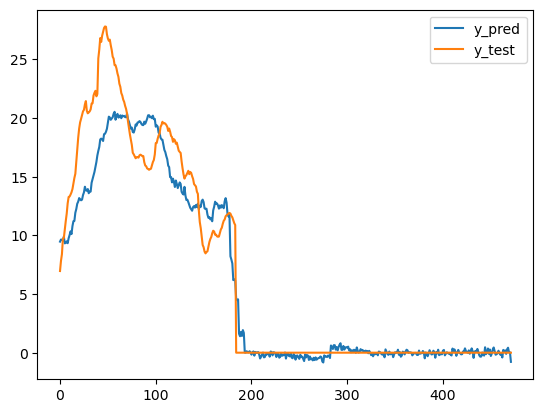

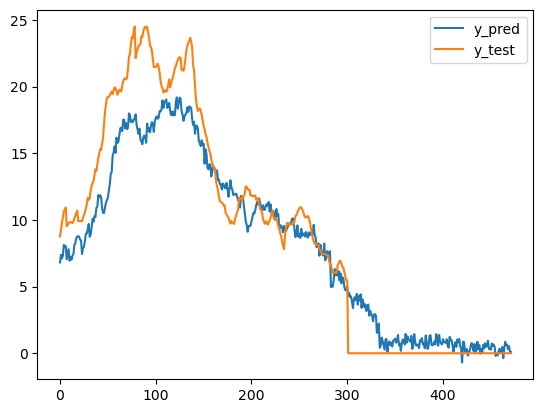

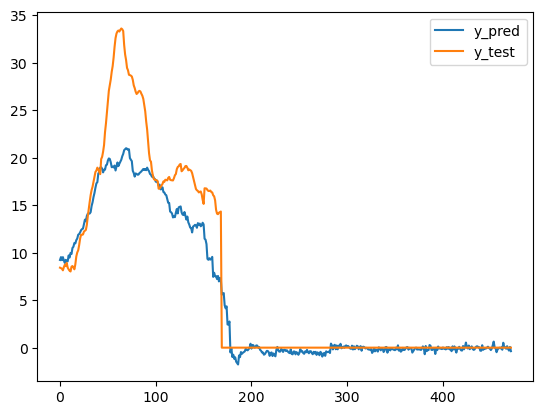

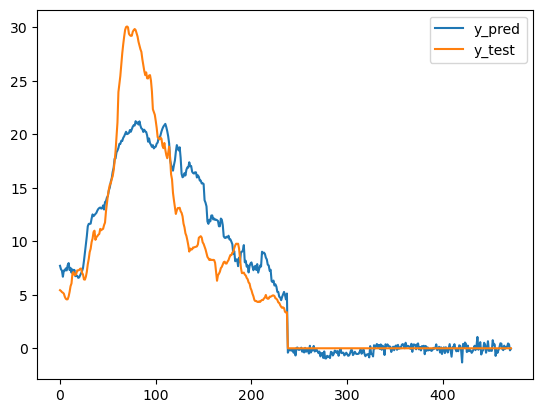

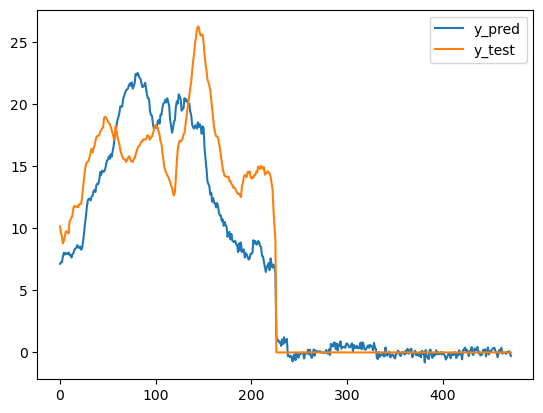

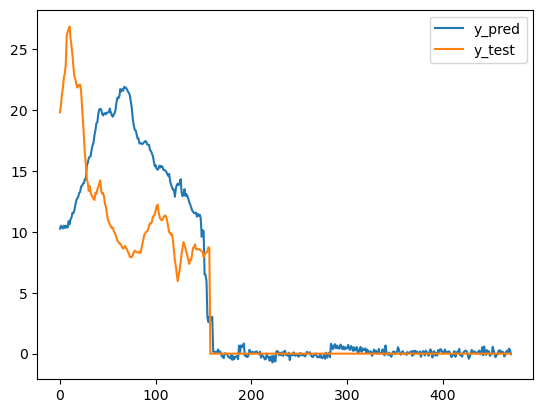

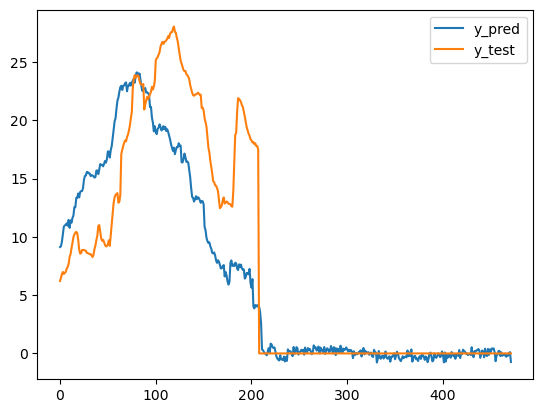

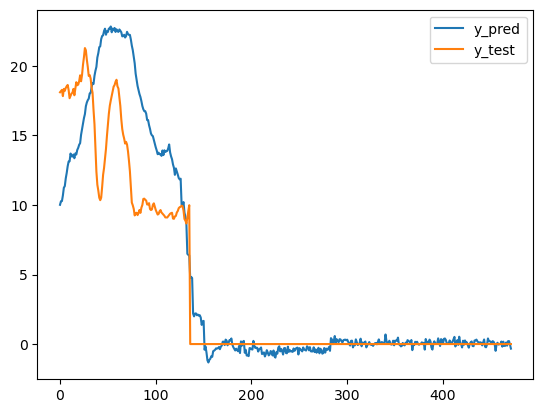

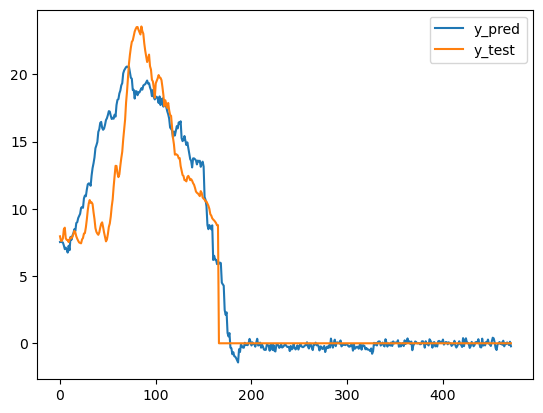

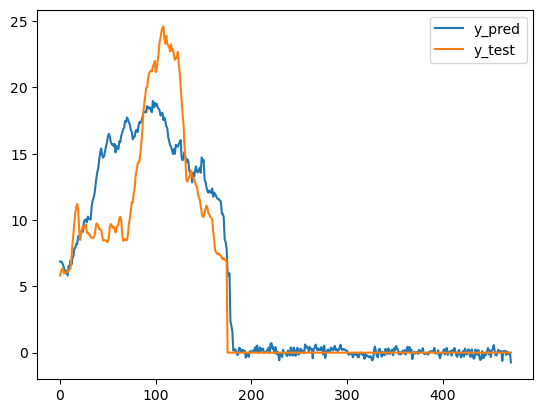

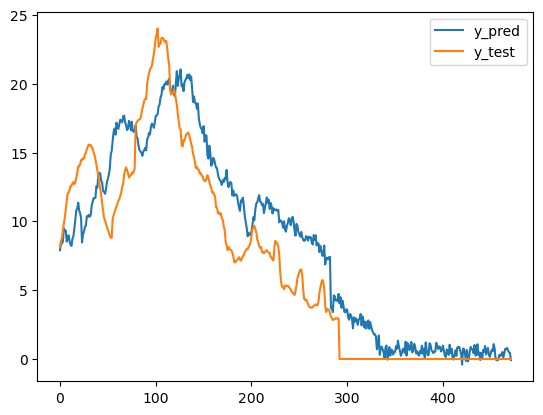

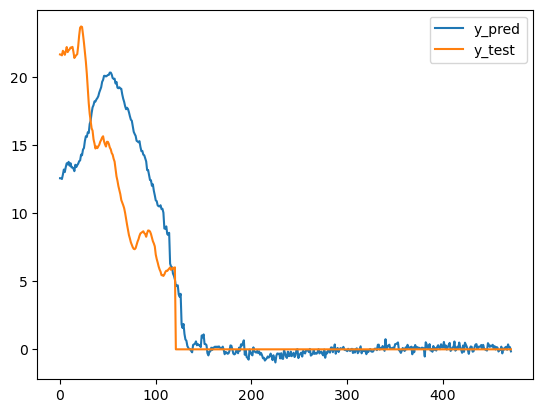

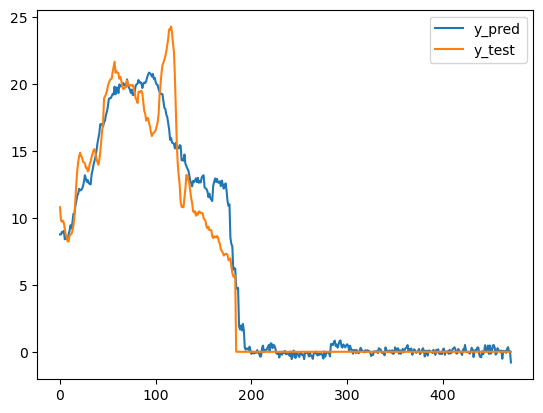

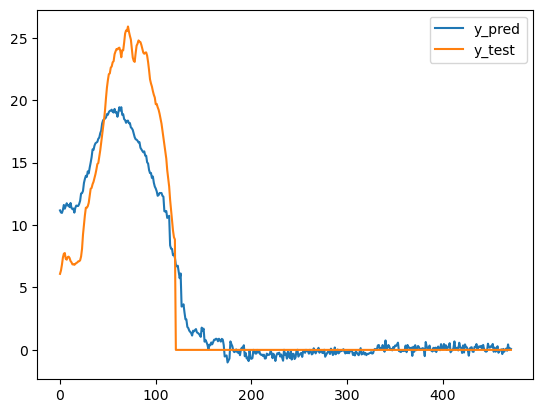

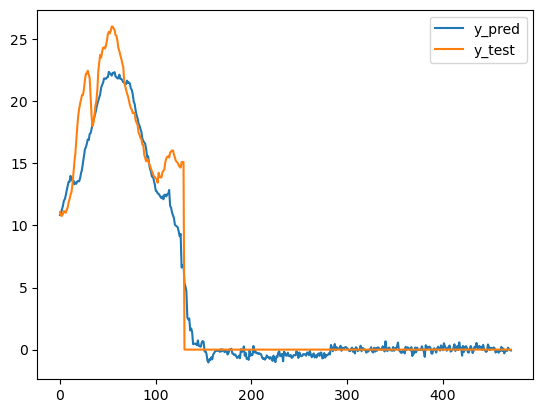

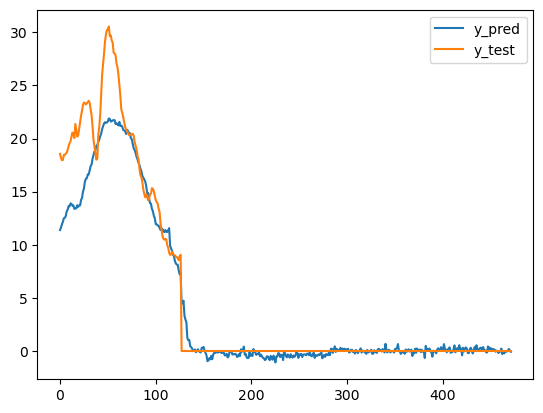

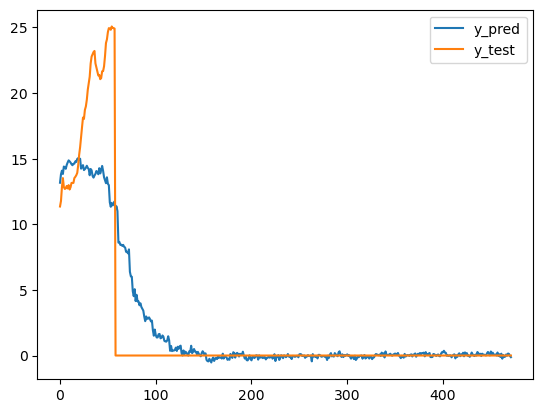

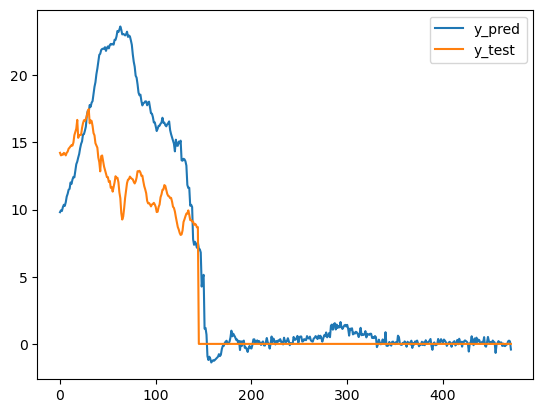

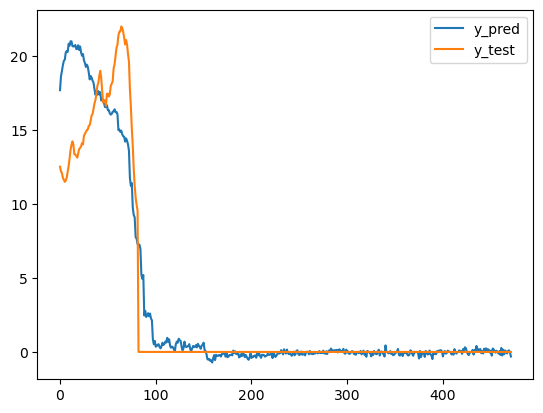

In [27]:
#best_model_2.save(f'{path}case_study/best_model_2.keras')
best_model_2 = tf.keras.models.load_model(f'{path}case_study/best_model_2.keras')
y_pred = best_model_2.predict(X_test)

for storms in range(19):
    plt.plot(y_pred[storms,:], label='y_pred')
    plt.plot(y_test[storms,:], label='y_test')
    plt.legend()
    plt.show()